In [9]:
import numpy as np
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt

from pykrx import stock
from dateutil import relativedelta
from warnings import filterwarnings
import scipy.stats as stats
import re

import scipy 
import scipy.optimize as opt
from scipy.optimize import minimize
import time
import pandas as pd
import matplotlib.pyplot as plt


filterwarnings('ignore')

In [2]:
def ch (name):
    cptype = name[7:8]
    maturity = name[9:15]
    strike = name[16:]

    return cptype+maturity+strike

def new_next_exp(today):

    next_mon = today + relativedelta.relativedelta(months=1)
    nnext_mon = next_mon + relativedelta.relativedelta(months=1)

    if today.day < 15:
        result = next_mon
    else:
        result = nnext_mon
        
    return result.strftime("%Y%m")

def op_chain_df (cpflag, maturity, strike, data_list, s0=None):
    
    idx = (cpflag, str(maturity), str(strike))    
    df = data_list[idx].dropna()

    k = float(strike)

    if s0 is None:
        df['행사가격'] = [k for x in range(len(df))]
        return df

    else:
        df['행사가격'] = [k for x in range(len(df))]
        df['기초자산가'] = s0.loc[df.index]
        return df


def option_date_creator (week, date):
    '''마지막 만기 거래일이 나옴'''
    base_date = dt.datetime.strptime(date, '%Y-%m')
    option_date = base_date + relativedelta.relativedelta(weekday=3) + dt.timedelta(weeks=week)
    option_date = option_date.strftime('%Y-%m-%d')

    return option_date

def svi_create (arr, K, F):
    a = arr[0]
    b = arr[1]
    rho = arr[2]
    m = arr[3]
    sig = arr[4]
    return (a + b * (rho * (np.log(K / F) - m) + np.sqrt((np.log(K/ F)-m)**2 + sig**2)))


def d1_cal (s, k ,r, q, iv, t) :
    return (np.log(s/k) + (r-q+iv**2/2)*t)/(iv*np.sqrt(t))

def d2_cal (s, k ,r, q, iv, t) :
    return d1_cal(s,k,r,q,iv,t) - iv * np.sqrt(t)

def density_cal (d2, k, svi, tau):
    return np.exp(-(d2**2)/2) / (svi * k * np.sqrt(2 * np.pi * tau))


# 데이터 불러오기

## 코스피200

In [3]:
kospi200 = stock.get_index_ohlcv('20050801', '20221130', '1028')['종가']

In [31]:
rf = pd.read_csv('./Data/rf.csv', parse_dates=['Date'], index_col=['Date'])
stock_q = stock.get_index_fundamental('20070801', '20221130', '1028')[['배당수익률']] / 100
futures = pd.read_csv('./Data/futures.csv',encoding='euckr', parse_dates=['일자'], index_col=['일자']).sort_index()
file_path = os.getcwd() + '/Data/'

df_close   = pd.read_pickle(file_path+'kospi200/'+'Call_data_close.pkl')
df_base    = pd.read_pickle(file_path+'kospi200/'+'Call_data_base.pkl')
df_volume  = pd.read_pickle(file_path+'kospi200/'+'Call_data_volume.pkl')
df_imvol   = pd.read_pickle(file_path+'kospi200/'+'Call_data_imvol.pkl')
df_open    = pd.read_pickle(file_path+'kospi200/'+'Call_data_open.pkl')

df_close2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_close.pkl')
df_base2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_base.pkl')
df_volume2  = pd.read_pickle(file_path+'kospi200/'+'Put_data_volume.pkl')
df_imvol2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_imvol.pkl')
df_open2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_open.pkl')

data_list = [df_close, df_base, df_volume, df_imvol, df_open,\
             df_close2, df_base2, df_volume2, df_imvol2, df_open2]

test = []
ttt = ['종가', '기준가', '거래량', '내재변동성', '미결제약정', '종가', '기준가', '거래량', '내재변동성', '미결제약정']

for idx, dfdfdfdf in enumerate(data_list):

    '''코스피일 경우엔 아래 진행'''

    tmp = dfdfdfdf.iloc[8:]
    tmp = tmp.set_axis(tmp.iloc[0], axis=1).drop(index=[8,9,10,11,12])

    tmp = tmp.rename(columns={tmp.columns[0] : 'Date'}).set_index('Date')
    tmp.index = pd.to_datetime(tmp.index)
    tmp.columns = [ch(x) for x in tmp.columns]

    '''코스피 아닐경우 바로 아래만 진행'''

    k_list = [x[7:] for x in tmp.columns]
    t_list = [x[1:7] for x in tmp.columns]
    c_list = [x[0] for x in tmp.columns]
    f_list = [ttt[idx] for x in tmp.columns]
    ppp = pd.DataFrame(data=tmp.values, index=tmp.index, columns=[c_list, t_list, k_list, f_list])
    test.append(ppp)

df = pd.concat(test, axis=1)#, keys=ttt)
#df.columns = df.columns.swaplevel(0, 1).swaplevel(1,2).swaplevel(2,3)
df.columns.names = ['cpflag', 'tick', 'strike', 'feature']
df

cpflag          C                                                          \
tick       200709                                                           
strike      165.0  167.5  170.0  172.5  175.0  177.5  180.0  182.5  185.0   
feature        종가     종가     종가     종가     종가     종가     종가     종가     종가   
Date                                                                        
2007-08-01   65.3  65.75   63.3   60.8  58.35   55.9  53.45     51   48.6   
2007-08-02   63.2   65.6   63.1  60.65   58.2  55.75   53.3   50.9  49.55   
2007-08-03  70.55  68.05     66   62.4  60.65   58.2  55.75  53.75  50.85   
2007-08-06   67.5  64.95   62.5     60   57.6   55.1   52.7  50.25  47.85   
2007-08-07     70  66.25  63.75   61.3  58.85  56.35   53.9  51.45     49   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-11-24    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-25    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

cpflag             ...      P                                                  \
tick               ... 202211                                                   
strike      187.5  ...  452.5 455.0 457.5 460.0 462.5 465.0 467.5 470.0 472.5   
feature        종가  ...  미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정   
Date               ...                                                          
2007-08-01   46.2  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-02  46.05  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-03  48.95  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-06   45.5  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-07   46.6  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...           ...  ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-11-24    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-25    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-28    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-29    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-30    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

cpflag            
tick              
strike     475.0  
feature    미결제약정  
Date              
2007-08-01   NaN  
2007-08-02   NaN  
2007-08-03   NaN  
2007-08-06   NaN  
2007-08-07   NaN  
...          ...  
2022-11-24   NaN  
2022-11-25   NaN  
2022-11-28   NaN  
2022-11-29   NaN  
2022-11-30   NaN  

[3789 rows x 84590 columns]

In [5]:
op_chain_df('C','200709','165.0', df, kospi200)

feature,종가,기준가,거래량,내재변동성,미결제약정,행사가격,기초자산가
Date,,,,,,,
2007-08-01,65.3,79.35,6,0.03,6414,165.0,234.36
2007-08-02,63.2,65.3,2,0.03,6414,165.0,233.84
2007-08-03,70.55,63.2,0,0.234,6414,165.0,236.91
2007-08-06,67.5,70.55,19,0.03,6426,165.0,233.92
2007-08-07,70,67.5,3,0.03,6427,165.0,234.50
2007-08-08,72,70,10,0.03,6437,165.0,240.07
2007-08-09,76.05,72,10,0.03,6439,165.0,241.00
2007-08-10,64.45,76.05,6,0.03,6438,165.0,230.68
2007-08-13,68.3,64.45,41,0.03,6472,165.0,233.88


## 삼성전자

In [11]:
samsung = pd.read_csv('./Data/spot_price.csv', index_col=['Date'], parse_dates=True)['samsung']
rf = pd.read_csv('./Data/rf.csv', parse_dates=['Date'], index_col=['Date'])
stock_q = stock.get_market_fundamental('20070801', '20221130', '005930')[['DIV']] / 100
futures = pd.read_csv('./Data/stock_futures.csv', index_col=['Date'], parse_dates=True).fillna('ffill')['samsung']
file_path = os.getcwd() + '/Data/'

df_close   = pd.read_pickle(file_path+'samsung/'+'Call_data_close.pkl')
df_base    = pd.read_pickle(file_path+'samsung/'+'Call_data_base.pkl')
df_volume  = pd.read_pickle(file_path+'samsung/'+'Call_data_volume.pkl')
df_imvol   = pd.read_pickle(file_path+'samsung/'+'Call_data_imvol.pkl')
df_open    = pd.read_pickle(file_path+'samsung/'+'Call_data_open.pkl')

df_close2   = pd.read_pickle(file_path+'samsung/'+'Put_data_close.pkl')
df_base2    = pd.read_pickle(file_path+'samsung/'+'Put_data_base.pkl')
df_volume2  = pd.read_pickle(file_path+'samsung/'+'Put_data_volume.pkl')
df_imvol2   = pd.read_pickle(file_path+'samsung/'+'Put_data_imvol.pkl')
df_open2    = pd.read_pickle(file_path+'samsung/'+'Put_data_open.pkl')

data_list = [df_close, df_base, df_volume, df_imvol, df_open,\
             df_close2, df_base2, df_volume2, df_imvol2, df_open2]

test = []
ttt = ['종가', '기준가', '거래량', '내재변동성', '미결제약정', '종가', '기준가', '거래량', '내재변동성', '미결제약정']

for idx, dfdfdfdf in enumerate(data_list):

    '''코스피일 경우엔 아래 진행'''

    tmp = dfdfdfdf.iloc[8:]
    tmp = tmp.set_axis(tmp.iloc[0], axis=1).drop(index=[8,9,10,11,12])

    tmp = tmp.rename(columns={tmp.columns[0] : 'Date'}).set_index('Date')
    tmp.index = pd.to_datetime(tmp.index)


    k_list = [x[7:] for x in tmp.columns]
    t_list = [x[1:7] for x in tmp.columns]
    c_list = [x[0] for x in tmp.columns]
    f_list = [ttt[idx] for x in tmp.columns]
    ppp = pd.DataFrame(data=tmp.values, index=tmp.index, columns=[c_list, t_list, k_list, f_list])
    test.append(ppp)

df = pd.concat(test, axis=1)#, keys=ttt)
#df.columns = df.columns.swaplevel(0, 1).swaplevel(1,2).swaplevel(2,3)
df.columns.names = ['cpflag', 'tick', 'strike', 'feature']
df

cpflag           C                                                          \
tick        200709                                                           
strike      500000 520000 540000 560000 580000 600000 620000 640000 660000   
feature         종가     종가     종가     종가     종가     종가     종가     종가     종가   
Date                                                                         
2007-08-01  100200  81600  64400  48800  35600  24800  16400  10400   6300   
2007-08-02  100200  81600  64400  48800  35600  24800  16400  10400   6300   
2007-08-03  100200  81600  64400  48800  35600  24800  16400  10400   6300   
2007-08-06  100200  81600  64400  48800  35600  24800  16400  10400   6300   
2007-08-07  100200  81600  64400  48800  35600  24800  16400  10400   6300   
...            ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-11-28     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-29     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-30     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-12-01     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-12-02     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

cpflag             ...      P                                                  \
tick               ... 202211                                                   
strike     680000  ...  49000 54000 56000 58000 60000 62000 64000 66000 68000   
feature        종가  ...  미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정   
Date               ...                                                          
2007-08-01   3650  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-02   3650  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-03   3650  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-06   3650  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-07   3650  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...           ...  ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-11-28    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-29    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-30    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-12-01    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-12-02    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

cpflag            
tick              
strike     70000  
feature    미결제약정  
Date              
2007-08-01   NaN  
2007-08-02   NaN  
2007-08-03   NaN  
2007-08-06   NaN  
2007-08-07   NaN  
...          ...  
2022-11-28   NaN  
2022-11-29   NaN  
2022-11-30   NaN  
2022-12-01   NaN  
2022-12-02   NaN  

[3791 rows x 32400 columns]

In [99]:
op_chain_df('C','202211','50000', df, samsung)

KeyboardInterrupt: 

## 한국전력

In [109]:
korea_electric = pd.read_csv('./Data/spot_price.csv', index_col=['Date'], parse_dates=True)['korea_electronic']
rf = pd.read_csv('./Data/rf.csv', parse_dates=['Date'], index_col=['Date'])
stock_q = stock.get_market_fundamental('20070801', '20221130', '015760')[['DIV']] / 100
futures = pd.read_csv('./Data/stock_futures.csv', index_col=['Date'], parse_dates=True).fillna('ffill')['korea_electronic']\
file_path = os.getcwd() + '/Data/'

df_close   = pd.read_pickle(file_path+'한전/'+'Call_data_close.pkl')
df_base    = pd.read_pickle(file_path+'한전/'+'Call_data_base.pkl')
df_volume  = pd.read_pickle(file_path+'한전/'+'Call_data_volume.pkl')
df_imvol   = pd.read_pickle(file_path+'한전/'+'Call_data_imvol.pkl')
df_open    = pd.read_pickle(file_path+'한전/'+'Call_data_open.pkl')

df_close2   = pd.read_pickle(file_path+'한전/'+'Put_data_close.pkl')
df_base2    = pd.read_pickle(file_path+'한전/'+'Put_data_base.pkl')
df_volume2  = pd.read_pickle(file_path+'한전/'+'Put_data_volume.pkl')
df_imvol2   = pd.read_pickle(file_path+'한전/'+'Put_data_imvol.pkl')
df_open2    = pd.read_pickle(file_path+'한전/'+'Put_data_open.pkl')

data_list = [df_close, df_base, df_volume, df_imvol, df_open,\
             df_close2, df_base2, df_volume2, df_imvol2, df_open2]

test = []
ttt = ['종가', '기준가', '거래량', '내재변동성', '미결제약정', '종가', '기준가', '거래량', '내재변동성', '미결제약정']

for idx, dfdfdfdf in enumerate(data_list):

    '''코스피일 경우엔 아래 진행'''

    tmp = dfdfdfdf.iloc[8:]
    tmp = tmp.set_axis(tmp.iloc[0], axis=1).drop(index=[8,9,10,11,12])

    tmp = tmp.rename(columns={tmp.columns[0] : 'Date'}).set_index('Date')
    tmp.index = pd.to_datetime(tmp.index)


    k_list = [x[7:] for x in tmp.columns]
    t_list = [x[1:7] for x in tmp.columns]
    c_list = [x[0] for x in tmp.columns]
    f_list = [ttt[idx] for x in tmp.columns]
    ppp = pd.DataFrame(data=tmp.values, index=tmp.index, columns=[c_list, t_list, k_list, f_list])
    test.append(ppp)

df = pd.concat(test, axis=1)#, keys=ttt)
#df.columns = df.columns.swaplevel(0, 1).swaplevel(1,2).swaplevel(2,3)
df.columns.names = ['cpflag', 'tick', 'strike', 'feature']
df

cpflag          C                                                        ...  \
tick       200709                                                        ...   
strike      34000 35000 36000 37000 38000 39000 40000 41000 42000 43000  ...   
feature        종가    종가    종가    종가    종가    종가    종가    종가    종가    종가  ...   
Date                                                                     ...   
2007-08-01   9600  8600  7600  6700  5700  4800  3900  3100  2400  1780  ...   
2007-08-02   9600  8600  7600  6700  5700  4800  3900  3100  2400  1780  ...   
2007-08-03   9600  8600  7600  6700  5700  4800  3900  3100  2400  1780  ...   
2007-08-06   9600  8600  7600  6700  5700  4800  3900  3100  2400  1780  ...   
2007-08-07   9600  8600  7600  6700  5700  4800  3900  3100  2400  1780  ...   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2022-11-28    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2022-11-29    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2022-11-30    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2022-12-01    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2022-12-02    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

cpflag          P                                                        
tick       202211                                                        
strike      18000 19500 18500 17000 16000 17500 15000 16500 15500 14500  
feature     미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정  
Date                                                                     
2007-08-01    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2007-08-02    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2007-08-03    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2007-08-06    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2007-08-07    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2022-11-28    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2022-11-29    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2022-11-30    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2022-12-01    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2022-12-02    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[3791 rows x 31230 columns]

In [110]:
op_chain_df('C','200709','43000',df, korea_electric)

feature,종가,기준가,거래량,내재변동성,미결제약정,행사가격,기초자산가
Date,,,,,,,
2007-08-01,1780,1780,0,0.239,0,43000.0,43000
2007-08-02,1780,1780,0,0.24,0,43000.0,42200
2007-08-03,1780,1780,0,0.24,0,43000.0,42400
2007-08-06,1780,1780,0,0.243,0,43000.0,41500
2007-08-07,1780,1780,0,0.243,0,43000.0,41500
2007-08-08,760,760,0,0.246,0,43000.0,42600
2007-08-09,760,760,0,0.246,0,43000.0,42850
2007-08-10,760,760,0,0.252,0,43000.0,41550
2007-08-13,760,760,0,0.255,0,43000.0,42600


## SKT

21년 10 28일 > 

In [111]:
skt = pd.read_csv('./Data/spot_price.csv', index_col=['Date'], parse_dates=True)['skt']
rf = pd.read_csv('./Data/rf.csv', parse_dates=['Date'], index_col=['Date'])
stock_q = stock.get_market_fundamental('20070801', '20221130', '017670')[['DIV']] / 100
futures = pd.read_csv('./Data/stock_futures.csv', index_col=['Date'], parse_dates=True).fillna('ffill')['skt']
file_path = os.getcwd() + '/Data/'

df_close   = pd.read_pickle(file_path+'SKT/'+'Call_data_close.pkl')
df_base    = pd.read_pickle(file_path+'SKT/'+'Call_data_base.pkl')
df_volume  = pd.read_pickle(file_path+'SKT/'+'Call_data_volume.pkl')
df_imvol   = pd.read_pickle(file_path+'SKT/'+'Call_data_imvol.pkl')
df_open    = pd.read_pickle(file_path+'SKT/'+'Call_data_open.pkl')

df_close2   = pd.read_pickle(file_path+'SKT/'+'Put_data_close.pkl')
df_base2    = pd.read_pickle(file_path+'SKT/'+'Put_data_base.pkl')
df_volume2  = pd.read_pickle(file_path+'SKT/'+'Put_data_volume.pkl')
df_imvol2   = pd.read_pickle(file_path+'SKT/'+'Put_data_imvol.pkl')
df_open2    = pd.read_pickle(file_path+'SKT/'+'Put_data_open.pkl')

data_list = [df_close, df_base, df_volume, df_imvol, df_open,\
             df_close2, df_base2, df_volume2, df_imvol2, df_open2]

test = []
ttt = ['종가', '기준가', '거래량', '내재변동성', '미결제약정', '종가', '기준가', '거래량', '내재변동성', '미결제약정']

for idx, dfdfdfdf in enumerate(data_list):

    '''코스피일 경우엔 아래 진행'''

    tmp = dfdfdfdf.iloc[8:]
    tmp = tmp.set_axis(tmp.iloc[0], axis=1).drop(index=[8,9,10,11,12])

    tmp = tmp.rename(columns={tmp.columns[0] : 'Date'}).set_index('Date')
    tmp.index = pd.to_datetime(tmp.index)

    k_list = [x[7:] for x in tmp.columns]
    t_list = [x[1:7] for x in tmp.columns]
    c_list = [x[0] for x in tmp.columns]
    f_list = [ttt[idx] for x in tmp.columns]
    ppp = pd.DataFrame(data=tmp.values, index=tmp.index, columns=[c_list, t_list, k_list, f_list])
    test.append(ppp)

df = pd.concat(test, axis=1)#, keys=ttt)
#df.columns = df.columns.swaplevel(0, 1).swaplevel(1,2).swaplevel(2,3)
df.columns.names = ['cpflag', 'tick', 'strike', 'feature']
df

cpflag          C                                                          \
tick       200709                                                           
strike     180000 185000 190000 195000 200000 210000 220000 230000 240000   
feature        종가     종가     종가     종가     종가     종가     종가     종가     종가   
Date                                                                        
2000-08-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2000-08-02    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2000-08-03    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2000-08-04    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2000-08-07    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-11-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-12-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-12-02    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

cpflag             ...      P                                                  \
tick               ... 202211                                                   
strike     250000  ...  54000 56000 58000 60000 62000 46000 48000 49000 47000   
feature        종가  ...  미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정   
Date               ...                                                          
2000-08-01    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2000-08-02    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2000-08-03    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2000-08-04    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2000-08-07    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...           ...  ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-11-28    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-29    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-30    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-12-01    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-12-02    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

cpflag            
tick              
strike     45000  
feature    미결제약정  
Date              
2000-08-01   NaN  
2000-08-02   NaN  
2000-08-03   NaN  
2000-08-04   NaN  
2000-08-07   NaN  
...          ...  
2022-11-28   NaN  
2022-11-29   NaN  
2022-11-30   NaN  
2022-12-01   NaN  
2022-12-02   NaN  

[5518 rows x 25860 columns]

In [112]:
op_chain_df('C','200709','180000',df, skt)

feature,종가,기준가,거래량,내재변동성,미결제약정,행사가격,기초자산가
Date,,,,,,,
2007-08-01,33200,33200,0,0.204,0,180000.0,202000
2007-08-02,33200,33200,0,0.199,0,180000.0,201500
2007-08-03,22800,22800,0,0.2,0,180000.0,204000
2007-08-06,22800,22800,0,0.2,0,180000.0,202000
2007-08-07,22800,22800,0,0.199,0,180000.0,202500
2007-08-08,22800,22800,0,0.2,0,180000.0,205000
2007-08-09,22800,22800,0,0.2,0,180000.0,205000
2007-08-10,22800,22800,0,0.212,0,180000.0,196500
2007-08-13,22800,22800,0,0.215,0,180000.0,201000


## 데이터내부의 K의 Boundary와 만기일

In [1247]:
ticker_list = [ch(x) for x in df_close.iloc[8].values][1:]
maturity_date = list(pd.Series([str(x[1:7]) for x in ticker_list]).unique())

upper = []
lower = []
k_list = []

for date in maturity_date:
    buffer = []
    for tick in ticker_list:
        if tick[1:7] == date:
            buffer.append(tick[7:])
        else:
            pass
    
    k_list.append(buffer)

    upper.append(buffer[np.argmax(buffer)])
    lower.append(buffer[np.argmin(buffer)])
    

reg = pd.DataFrame(data=[upper, lower], columns=maturity_date).T.rename(columns={0:'Upper', 1:'Lower'}).astype(float)
reg
reg['last_trade_date'] = [option_date_creator(1, f'{x[:4]}-{x[4:]}') for x in reg.index]
reg['k_list'] = k_list
reg

,Upper,Lower,last_trade_date,k_list
200709,270.0,165.0,2007-09-13,"[165.0, 167.5, 170.0, 172.5, 175.0, 177.5, 180..."
200710,275.0,192.5,2007-10-11,"[192.5, 195.0, 197.5, 200.0, 202.5, 205.0, 207..."
200711,277.5,192.5,2007-11-08,"[192.5, 195.0, 197.5, 200.0, 202.5, 205.0, 207..."
200712,277.5,195.0,2007-12-13,"[195.0, 197.5, 200.0, 202.5, 205.0, 207.5, 210..."
200801,277.5,210.0,2008-01-10,"[210.0, 212.5, 215.0, 217.5, 220.0, 222.5, 225..."
...,...,...,...,...
202207,515.0,222.5,2022-07-14,"[222.5, 225.0, 227.5, 230.0, 232.5, 235.0, 237..."
202208,490.0,222.5,2022-08-11,"[222.5, 225.0, 227.5, 230.0, 232.5, 235.0, 237..."
202209,520.0,220.0,2022-09-08,"[220.0, 222.5, 225.0, 227.5, 230.0, 232.5, 235..."
202210,480.0,180.0,2022-10-13,"[180.0, 182.5, 185.0, 187.5, 190.0, 192.5, 195..."


# Skew and Kurt

IV and Close 보기

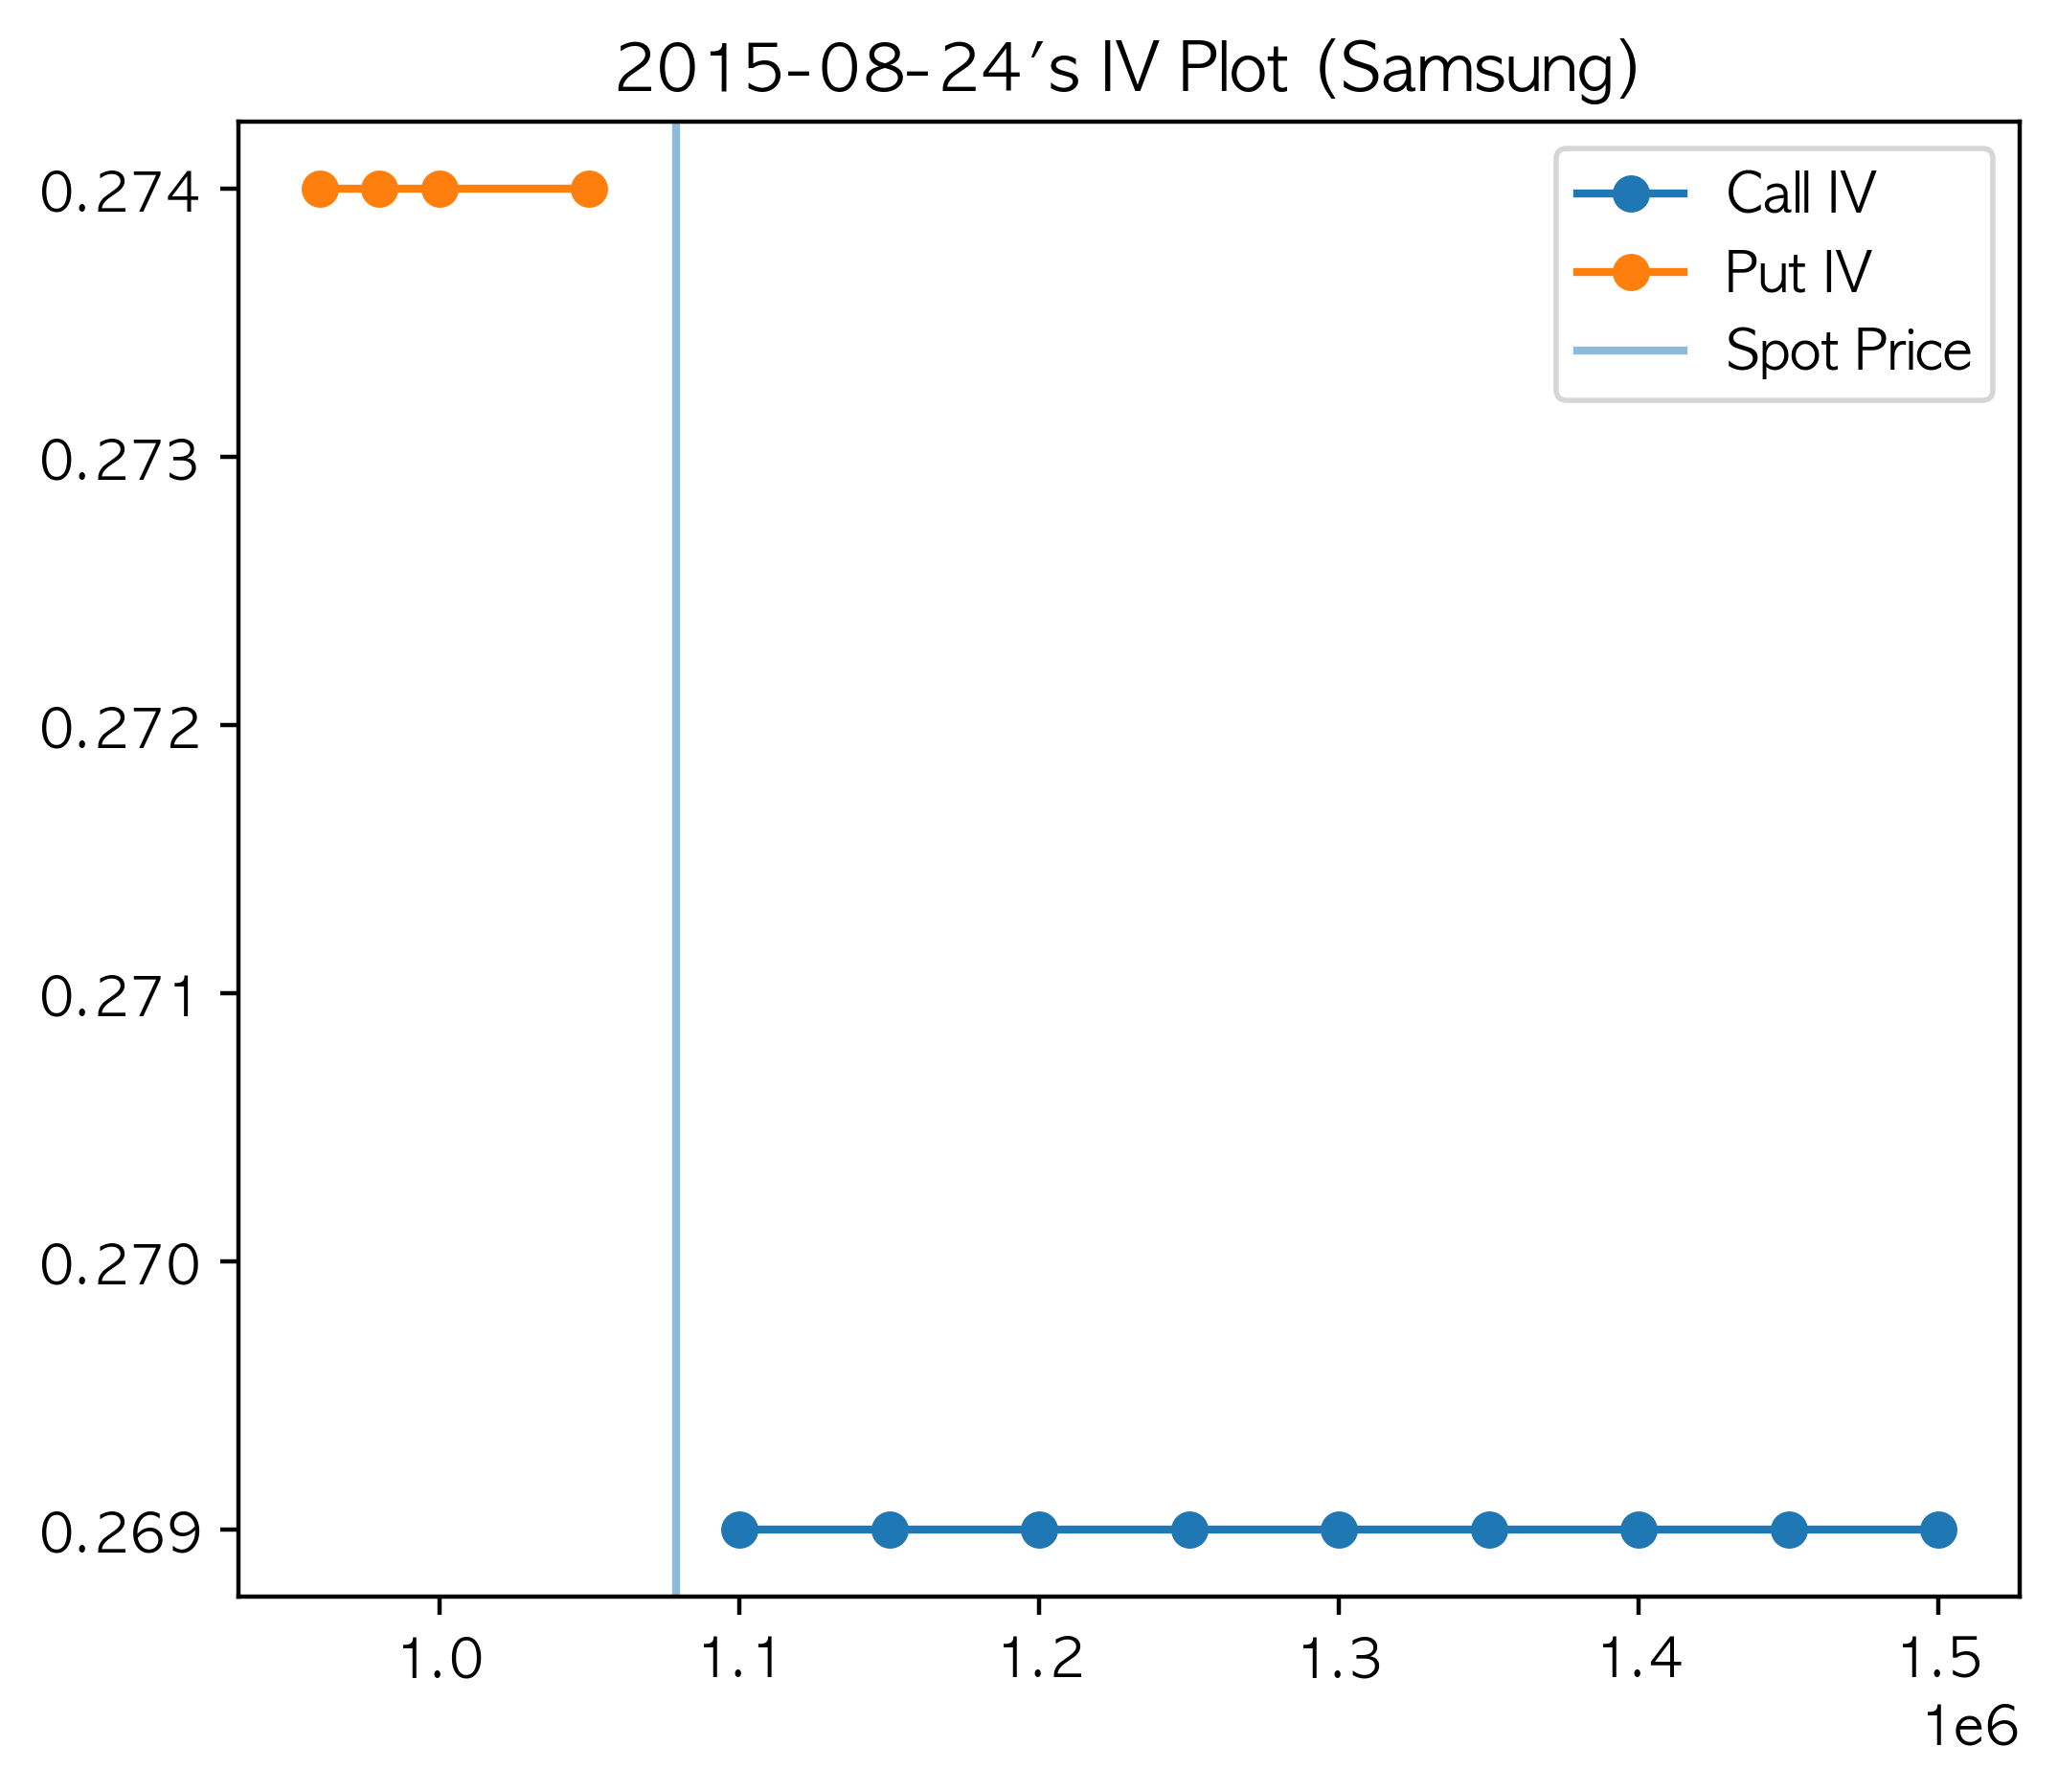

In [29]:
date_idx = df.index[2000]
date = dt.datetime.strftime(date_idx, '%Y-%m-%d')
# date = '2019-05-03'
# date_idx = dt.datetime.strptime(date, '%Y-%m-%d')
ex_date = new_next_exp(date_idx)
op_ex_date = option_date_creator(1, ex_date[0:4]+'-'+ex_date[4:6])
date_idx, ex_date

'''특정 일자의 IV Columns'''

spot = samsung.loc[date]

call_iv = df.loc[date, ('C', ex_date, slice(None), '내재변동성')]
put_iv  = df.loc[date, ('P', ex_date, slice(None), '내재변동성')]

call_iv_df = pd.DataFrame(call_iv).reset_index()
put_iv_df  = pd.DataFrame(put_iv).reset_index()

call_iv_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'iv')
put_iv_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'iv')

call_iv_df[['strike', 'iv']] = call_iv_df[['strike', 'iv']].astype(float)
put_iv_df[['strike', 'iv']]  = put_iv_df[['strike', 'iv']].astype(float)

k_list = np.unique(np.concatenate([call_iv_df['strike'].values, put_iv_df['strike'].values]))

call_list = k_list[np.where(k_list>=spot)]
put_list = k_list[np.where(k_list<spot)]

c_iv = call_iv_df.set_index('strike').loc[call_list]['iv']
p_iv = put_iv_df.set_index('strike').loc[put_list]['iv']

plt.figure(figsize=(6, 5), dpi=400)
plt.title(f"{date}'s IV Plot (Samsung)")

# aaaaaa = pd.concat([p_iv, c_iv]).sort_index().dropna()
# plt.scatter(aaaaaa.index, aaaaaa, label='Put IV')

plt.plot(c_iv, '-o', label='Call IV')
plt.plot(p_iv, '-o', label='Put IV')

plt.axvline(spot, label='Spot Price', alpha=0.5)
plt.legend()
plt.show()

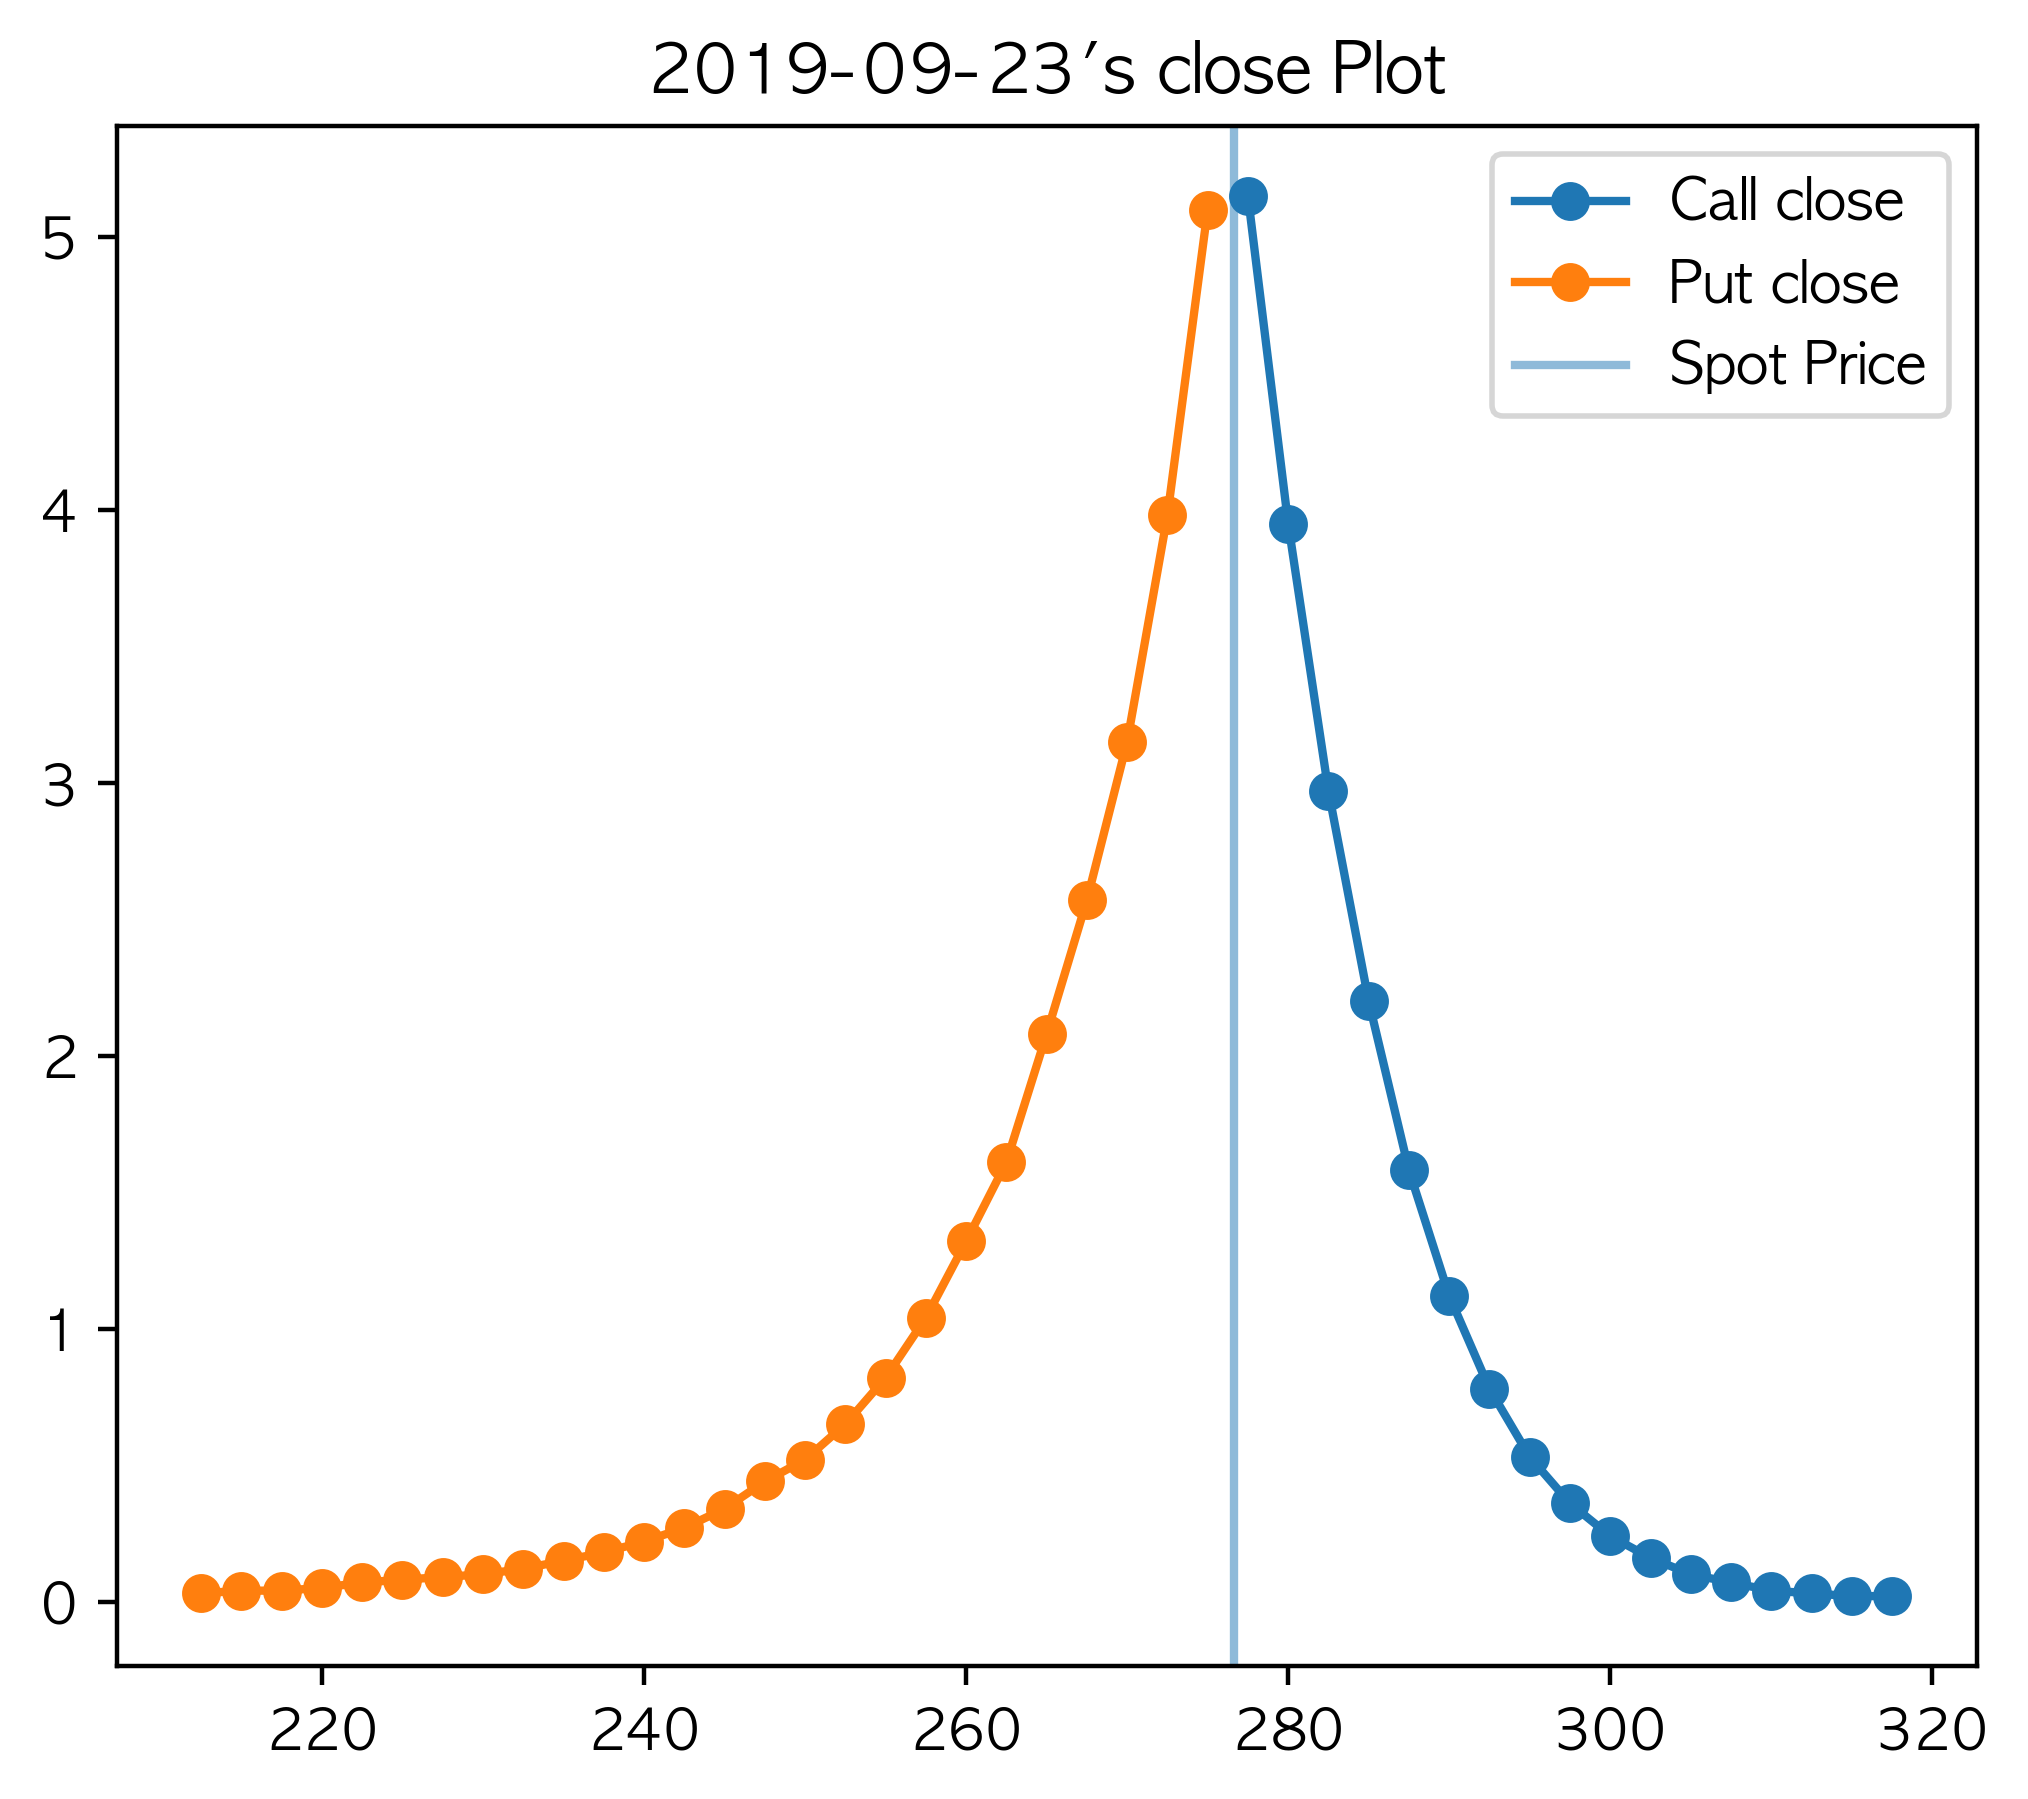

In [145]:
'''특정 일자의 close Columns'''
spot = kospi200.loc[date]

call_close = df.loc[date, ('C', ex_date, slice(None), '종가')]
put_close  = df.loc[date, ('P', ex_date, slice(None), '종가')]

call_close_df = pd.DataFrame(call_close).reset_index()
put_close_df  = pd.DataFrame(put_close).reset_index()

call_close_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'close')
put_close_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'close')

call_close_df[['strike', 'close']] = call_close_df[['strike', 'close']].astype(float)
put_close_df[['strike', 'close']]  = put_close_df[['strike', 'close']].astype(float)

k_list = np.unique(np.concatenate([call_close_df['strike'].values, put_close_df['strike'].values]))

call_list = k_list[np.where(k_list>=spot)]
put_close_list = k_list[np.where(k_list<spot)]

c_close = call_close_df.set_index('strike').loc[call_list]['close']
p_close = put_close_df.set_index('strike').loc[put_close_list]['close']

plt.figure(figsize=(6, 5), dpi=400)
plt.title(f"{date}'s close Plot")
plt.plot(c_close, '-o', label='Call close')
plt.plot(p_close, '-o', label='Put close')
plt.axvline(spot, label='Spot Price', alpha=0.5)
plt.legend()
plt.show()

In [108]:
y1_l

0.256

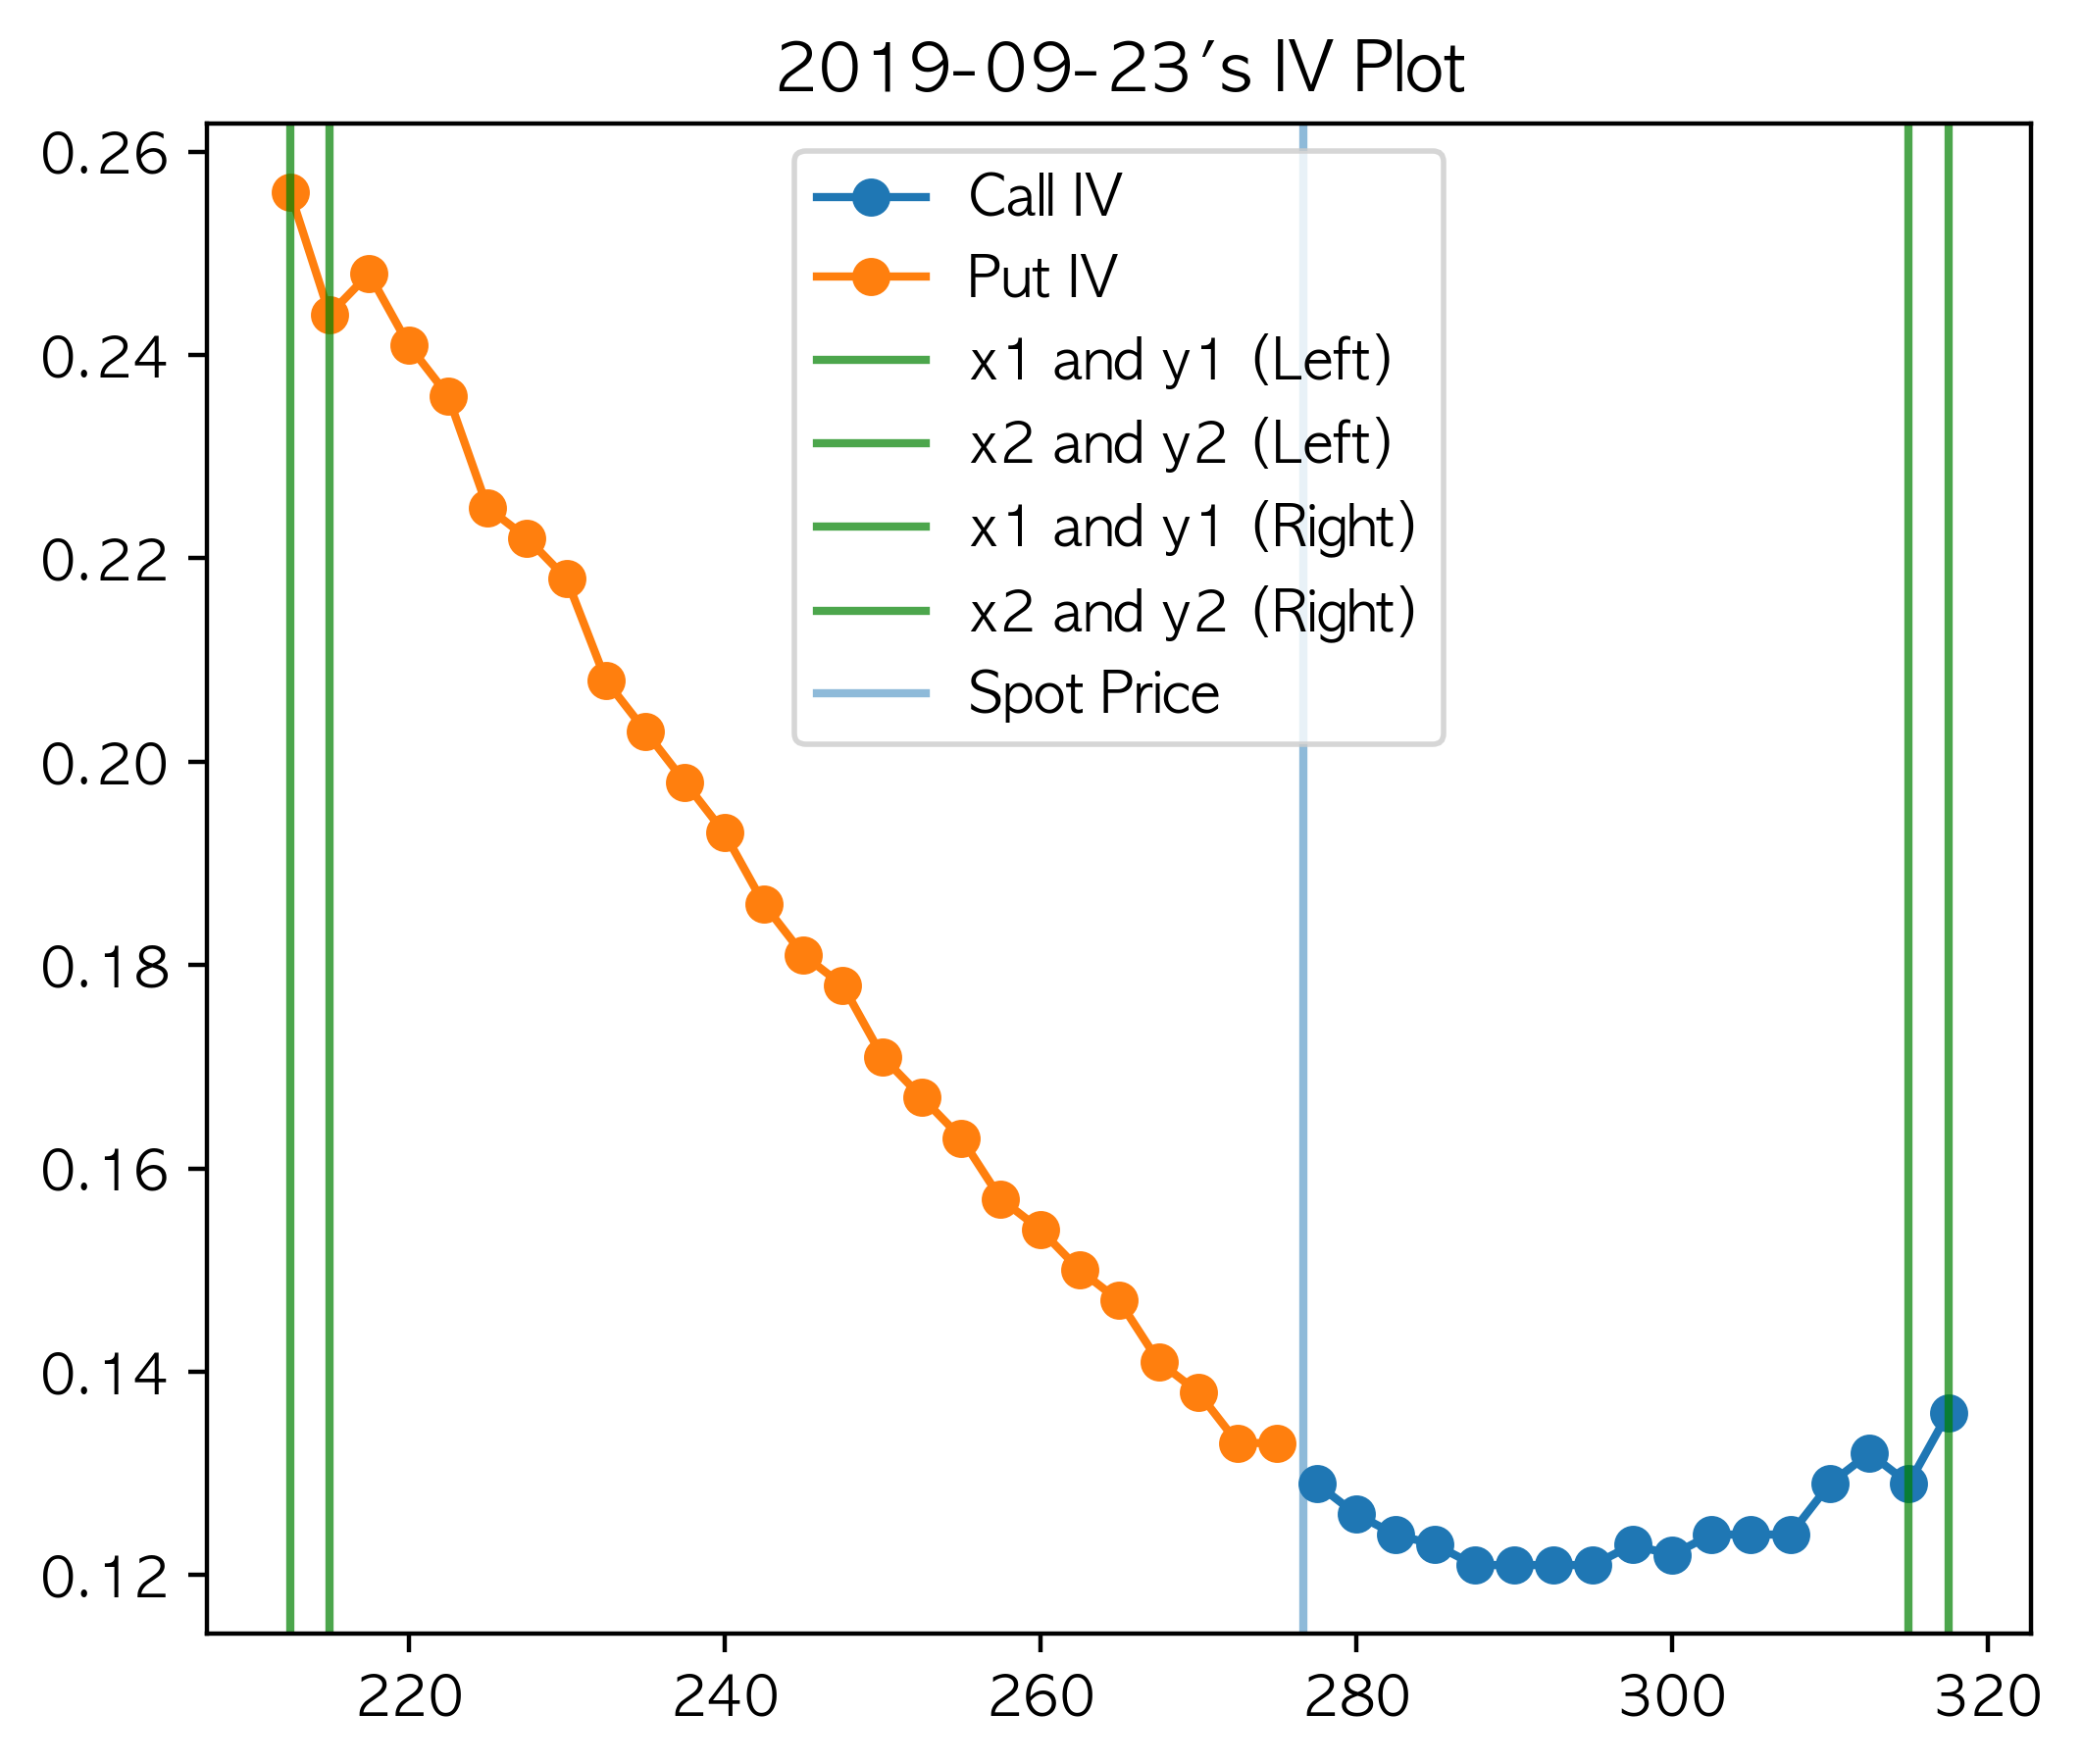

In [146]:
data = pd.DataFrame(pd.concat([c_iv, p_iv]).sort_index().dropna())

'''params'''
tau = (dt.datetime.strptime(op_ex_date, '%Y-%m-%d') - date_idx).days / 365
r = rf.loc[date].item()
futures = pd.read_csv('./Data/futures.csv',encoding='euckr', parse_dates=['일자'], index_col=['일자']).sort_index()
'''개별 주식은 종가 없이'''
futures = futures.loc[date]['종가']
#futures = futures.loc[date]

q = stock_q.loc[date].item() / 100

init = data

y1_l = init.iloc[0].item()
y2_l = init.iloc[1].item()
x1_l = init.index[0].item()
x2_l = init.index[1].item()

y1_r = init.iloc[-2].item()
y2_r = init.iloc[-1].item()
x1_r = init.index[-2].item()
x2_r = init.index[-1].item()

l_a = ((y2_l - y1_l) / (x2_l - x1_l))
l_b = (x1_l * y2_l - x2_l * y1_l) / (x1_l - x2_l)
r_a = (y2_r - y1_r) / (x2_r - x1_r)
r_b = (x1_r * y2_r - x2_r * y1_r) / (x1_r - x2_r)

a = l_b + l_a * ((r_b - l_b)/(l_a - r_a))
b = (r_a -l_a)/2
rho = (r_a + l_a) / (r_a - l_a)
m = l_a * (r_b-l_b) / (b*(l_a-r_a)*(rho-1))
sig = init.values[np.argmin(init)].item()**2

init['iv^2'] = init['iv']**2
init['k'] = np.log(init.index / futures)

def svi (arr):
    a = arr[0]
    b = arr[1]
    rho = arr[2]
    m = arr[3]
    sig = arr[4]
    return (a + b * (rho * (init['k'] - m) + np.sqrt((init['k']-m)**2 + sig**2)))

def mse(arr):

    return np.sum((init['iv^2'] - svi(arr))**2)
    
boundary = ((0.001, 0.009), (0, 0.5), (-0.5, 0.5), (-0.05, 0), (0, 0.05))

init_point = np.array([a, b, rho, m ,sig])
opt = minimize(mse, init_point, method='SLSQP', bounds=boundary)
init['svi'] = svi(opt['x'])**0.5

plt.figure(figsize=(6, 5), dpi=400)
plt.title(f"{date}'s IV Plot")

# aaaaaa = pd.concat([p_iv, c_iv]).sort_index().dropna()
# plt.scatter(aaaaaa.index, aaaaaa, label='Put IV')

plt.plot(c_iv, '-o', label='Call IV')
plt.plot(p_iv, '-o', label='Put IV')

plt.axvline(x1_l, label='x1 and y1 (Left)', alpha=0.7, color='g')
plt.axvline(x2_l, label='x2 and y2 (Left)', alpha=0.7, color='g')
plt.axvline(x1_r, label='x1 and y1 (Right)', alpha=0.7, color='g')
plt.axvline(x2_r, label='x2 and y2 (Right)', alpha=0.7, color='g')

plt.axvline(spot, label='Spot Price', alpha=0.5)

plt.legend()
plt.show()

In [123]:
x1_l

212.5

In [137]:
new_iv_df.iv

248    0.179471
249    0.177300
250    0.175120
251    0.172932
252    0.170736
         ...   
354    0.160329
355    0.160910
356    0.161487
357    0.162061
358    0.162632
Name: iv, Length: 111, dtype: float64

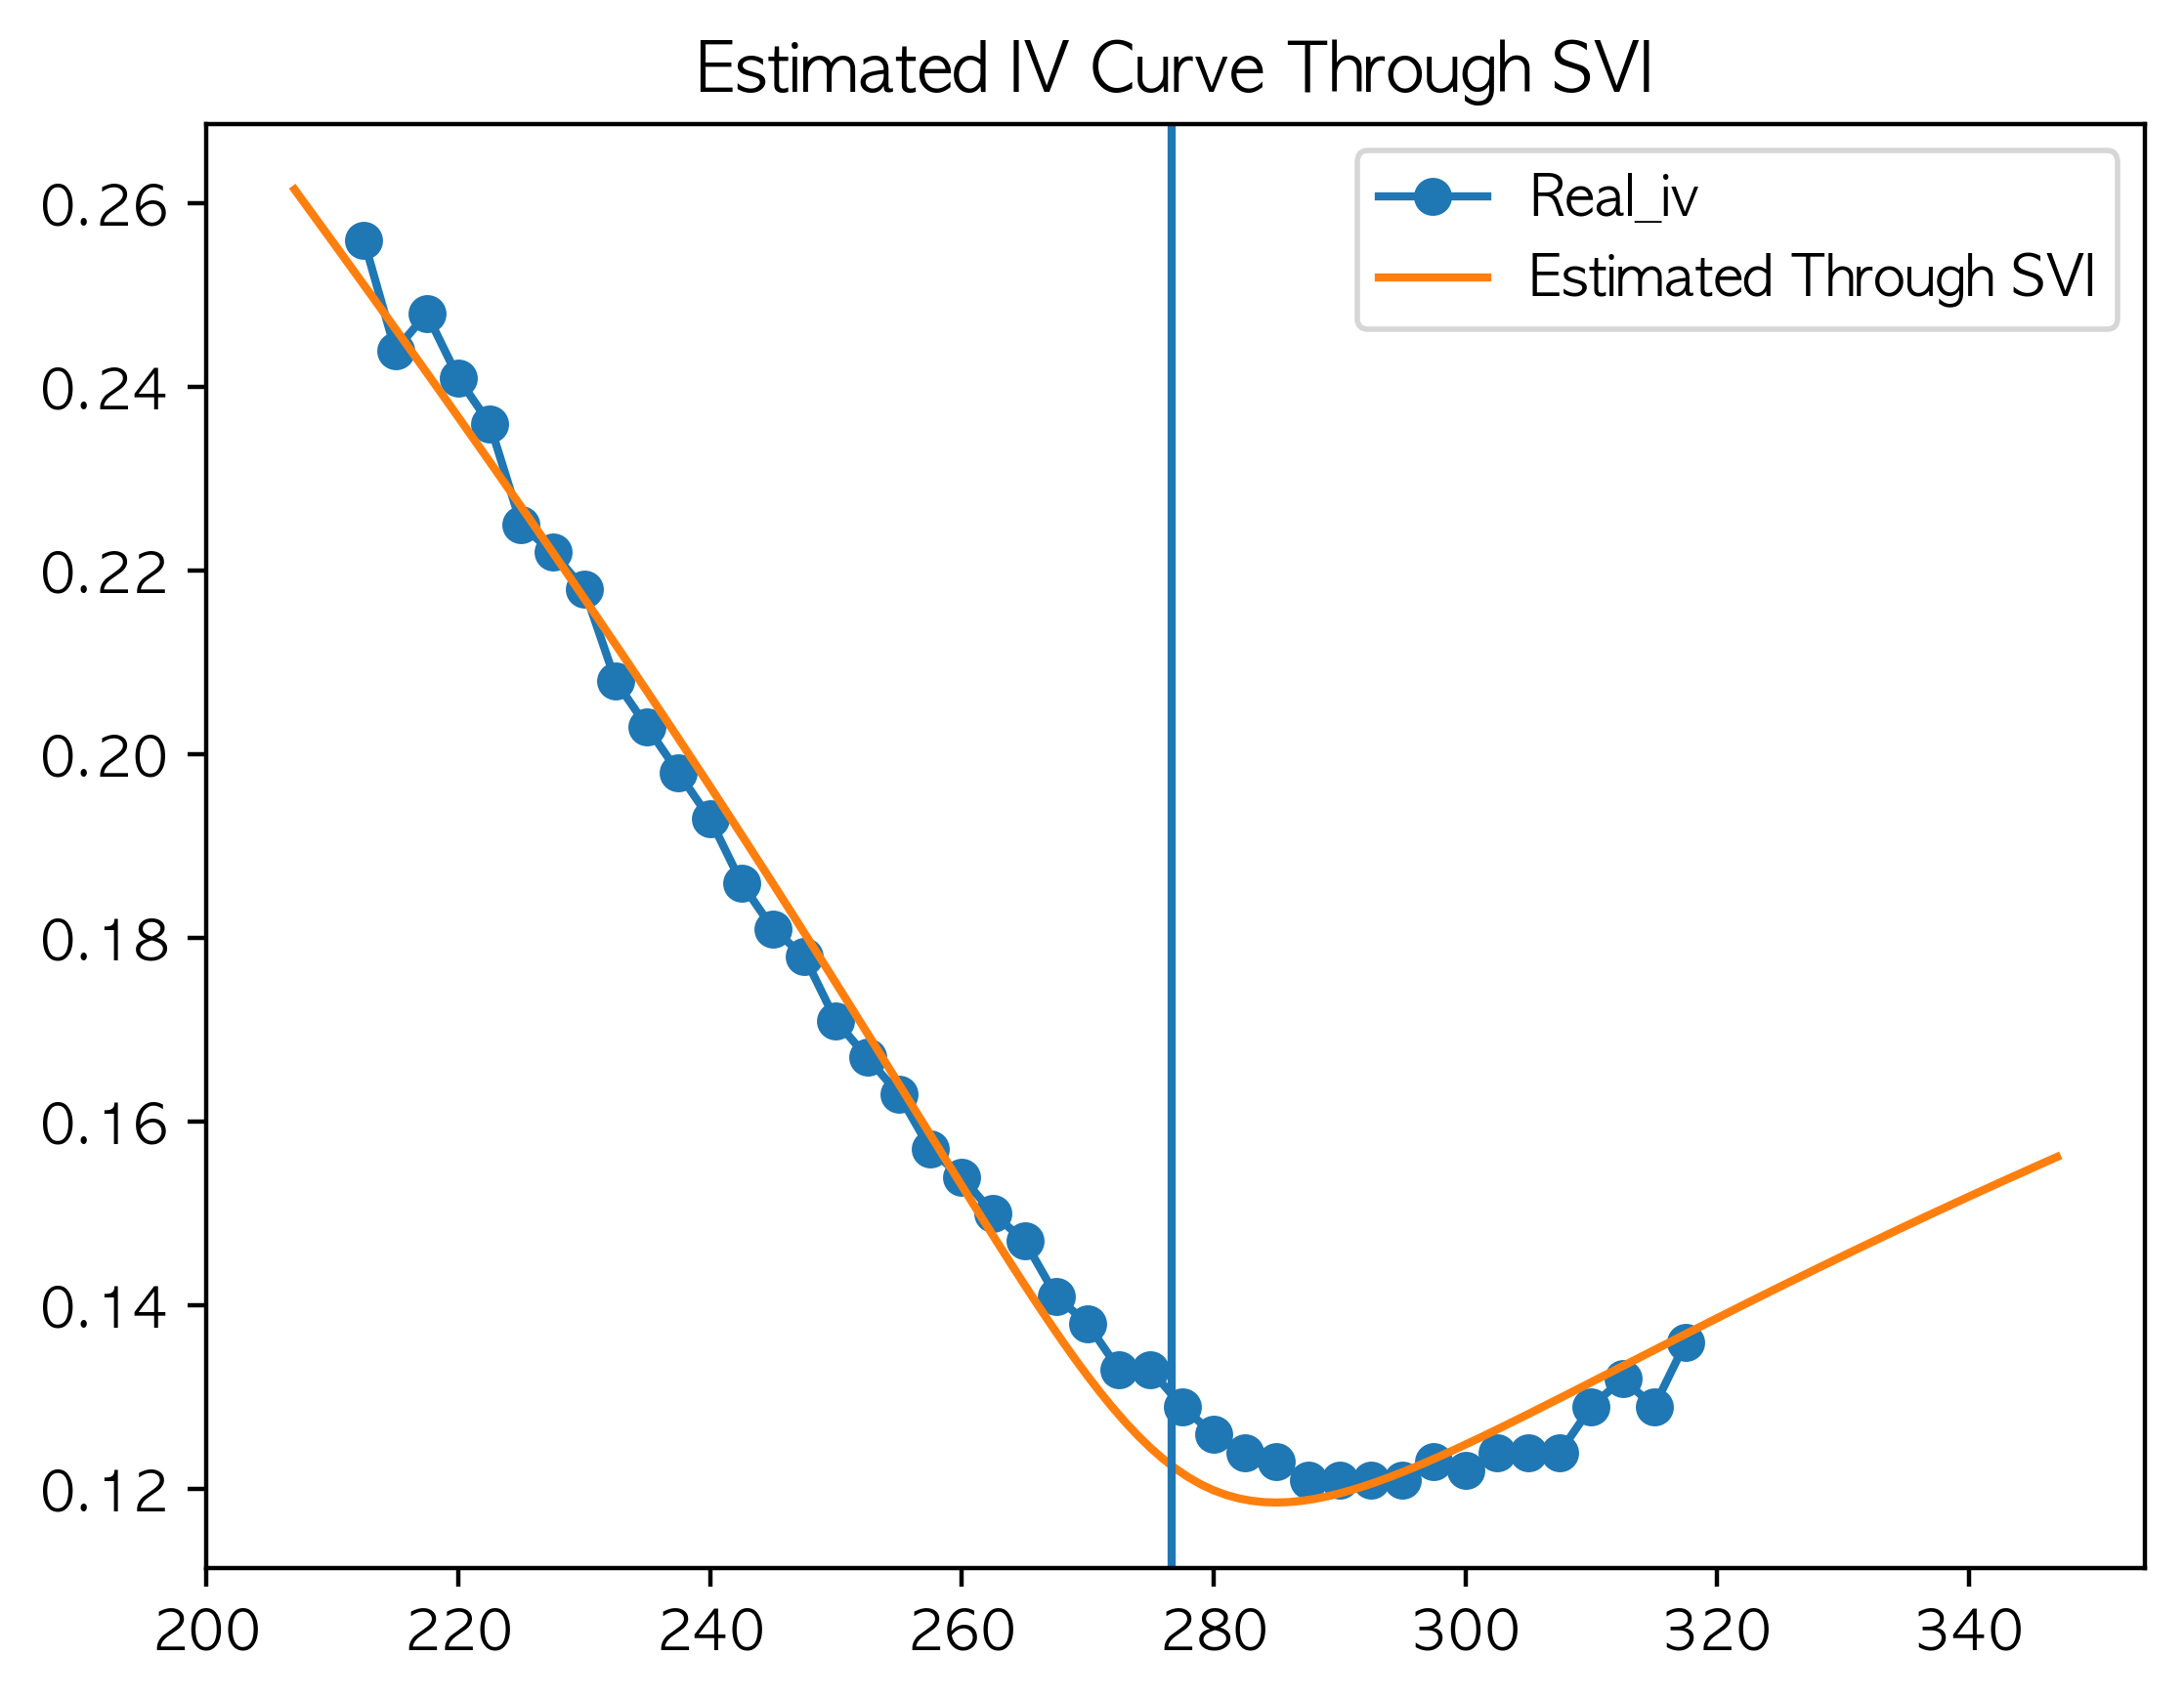

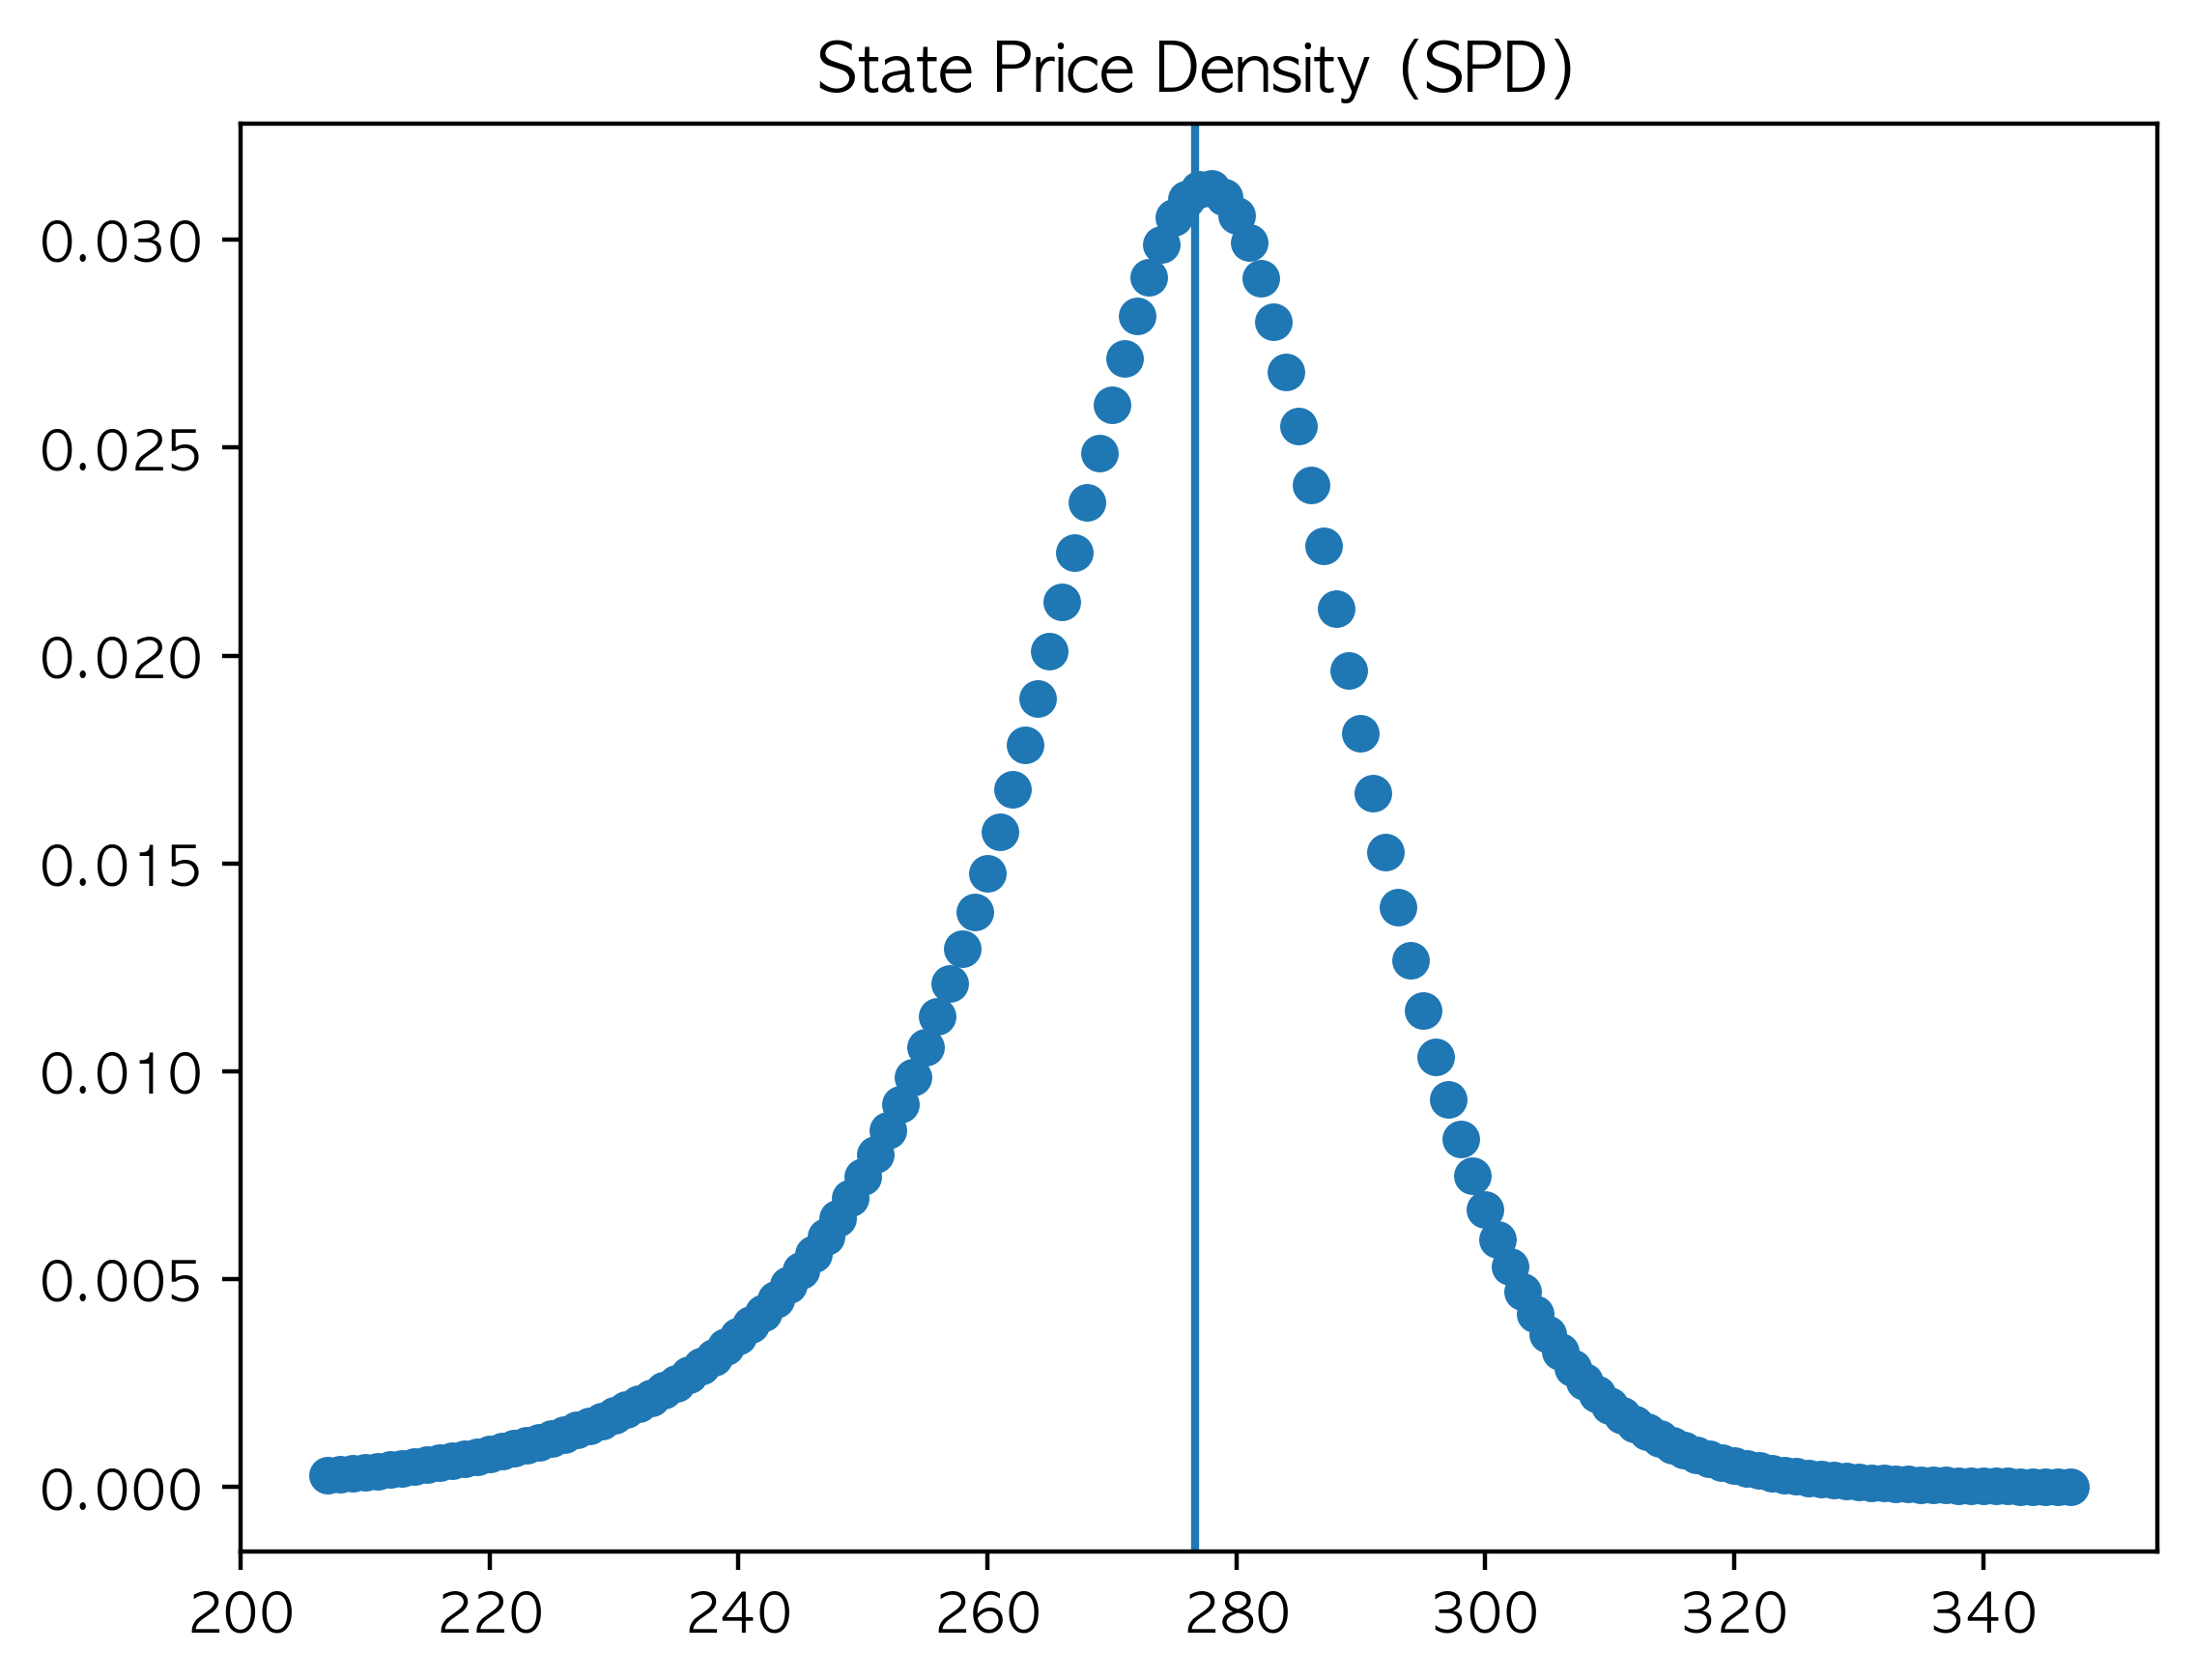

2019-09-23's kurtosis = -0.01625524705440684, Skew = 1.174466246478742


In [147]:
kkk = np.arange(int(spot - spot*0.25), int(spot + spot*0.26), 1)

new_iv = svi_create(opt['x'], kkk, futures)**0.5
new_iv_df = pd.DataFrame(new_iv, index=kkk, columns=['iv'])

plt.figure(dpi=400)
#plt.plot(new_iv_df['iv'], label='New_IV')
plt.title('Estimated IV Curve Through SVI')
plt.plot(init['iv'], '-o', label='Real_iv')
plt.plot(new_iv_df.iv, label='Estimated Through SVI')
plt.axvline(spot)
plt.legend()
plt.show()

new_iv_df['d2'] = d2_cal(spot, new_iv_df['iv'].index.to_numpy(), r, q, new_iv_df['iv'].to_numpy(), tau)
new_iv_df['Density'] = density_cal(new_iv_df['d2'], new_iv_df.index, new_iv_df['iv'], tau)

plt.figure(dpi=400)
#plt.plot(new_iv_df['iv'], label='New_IV')
plt.title('State Price Density (SPD)')
plt.scatter(new_iv_df.index, new_iv_df['Density'])
plt.axvline(spot)
plt.show()

kurt = new_iv_df['Density'].kurt()
sk = new_iv_df['Density'].skew()

print(f"{date}'s kurtosis = {kurt}, Skew = {sk}")

In [7]:
from tqdm import tqdm

In [10]:
kurt_list = []
skew_list = []

for datetime_idx in tqdm(range(len(df.index))):

    try:
        '''Date Params'''
    
        date_idx = df.index[datetime_idx]
        date = dt.datetime.strftime(date_idx, '%Y-%m-%d')
        spot = kospi200.loc[date]
        ex_date = new_next_exp(date_idx)
        op_ex_date = option_date_creator(1, ex_date[0:4]+'-'+ex_date[4:6])
        
        '''IV params'''
        call_iv = df.loc[date, ('C', ex_date, slice(None), '내재변동성')]
        put_iv  = df.loc[date, ('P', ex_date, slice(None), '내재변동성')]

        call_iv_df = pd.DataFrame(call_iv).reset_index()
        put_iv_df  = pd.DataFrame(put_iv).reset_index()

        call_iv_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'iv')
        put_iv_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'iv')

        call_iv_df[['strike', 'iv']] = call_iv_df[['strike', 'iv']].astype(float)
        put_iv_df[['strike', 'iv']]  = put_iv_df[['strike', 'iv']].astype(float)

        k_list = np.unique(np.concatenate([call_iv_df['strike'].values, put_iv_df['strike'].values]))


        call_list = k_list[np.where(k_list>=spot)]
        put_list = k_list[np.where(k_list<spot)]

        c_iv = call_iv_df.set_index('strike').loc[call_list]['iv']
        p_iv = put_iv_df.set_index('strike').loc[put_list]['iv']

        '''Close Params'''
        call_close = df.loc[date, ('C', ex_date, slice(None), '종가')]
        put_close  = df.loc[date, ('P', ex_date, slice(None), '종가')]

        call_close_df = pd.DataFrame(call_close).reset_index()
        put_close_df  = pd.DataFrame(put_close).reset_index()

        call_close_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'close')
        put_close_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'close')

        call_close_df[['strike', 'close']] = call_close_df[['strike', 'close']].astype(float)
        put_close_df[['strike', 'close']]  = put_close_df[['strike', 'close']].astype(float)

        k_list = np.unique(np.concatenate([call_close_df['strike'].values, put_close_df['strike'].values]))

        call_list = k_list[np.where(k_list>=spot)]
        put_close_list = k_list[np.where(k_list<spot)]

        c_close = call_close_df.set_index('strike').loc[call_list]['close']
        p_close = put_close_df.set_index('strike').loc[put_close_list]['close']

        '''IV Interpolation (SVI)'''
        data = pd.DataFrame(pd.concat([c_iv, p_iv]).sort_index().dropna())

        '''params'''
        tau = (dt.datetime.strptime(op_ex_date, '%Y-%m-%d') - date_idx).days / 365
        r = rf.loc[date].item()
        futures = pd.read_csv('./Data/futures.csv',encoding='euckr', parse_dates=['일자'], index_col=['일자']).sort_index()
        futures = futures.loc[date]['종가']
        q = stock_q.loc[date].item() / 100

        '''Initial Coef Cal'''
        init = data

        y1_l = init.iloc[0].item()
        y2_l = init.iloc[1].item()
        x1_l = init.index[0].item()
        x2_l = init.index[1].item()

        y1_r = init.iloc[-2].item()
        y2_r = init.iloc[-1].item()
        x1_r = init.index[-2].item()
        x2_r = init.index[-1].item()

        l_a = ((y2_l - y1_l) / (x2_l - x1_l))
        l_b = (x1_l * y2_l - x2_l * y1_l) / (x1_l - x2_l)
        r_a = (y2_r - y1_r) / (x2_r - x1_r)
        r_b = (x1_r * y2_r - x2_r * y1_r) / (x1_r - x2_r)

        a = l_b + l_a * ((r_b - l_b)/(l_a - r_a))
        b = (r_a -l_a)/2
        rho = (r_a + l_a) / (r_a - l_a)
        m = l_a * (r_b-l_b) / (b*(l_a-r_a)*(rho-1))
        sig = init.values[np.argmin(init)].item()**2

        '''Opt Start'''
        init['iv^2'] = init['iv']**2
        init['k'] = np.log(init.index / futures)

        def svi (arr):
            a = arr[0]
            b = arr[1]
            rho = arr[2]
            m = arr[3]
            sig = arr[4]
            return (a + b * (rho * (init['k'] - m) + np.sqrt((init['k']-m)**2 + sig**2)))

        def mse(arr):

            return np.sum((init['iv^2'] - svi(arr))**2)
            
        boundary = ((0.001, 0.009), (0, 0.5), (-0.5, 0.5), (-0.05, 0), (0, 0.05))

        init_point = np.array([a, b, rho, m ,sig])
        opt = minimize(mse, init_point, method='SLSQP', bounds=boundary)
        init['svi'] = svi(opt['x'])**0.5

        kkk = np.arange(int(spot - spot*0.25), int(spot + spot*0.26), 1)

        new_iv = svi_create(opt['x'], kkk, futures)**0.5
        new_iv_df = pd.DataFrame(new_iv, index=kkk, columns=['iv'])

        # #plt.plot(new_iv_df['iv'], label='New_IV')
        # plt.plot(init['iv'], label='Real_iv')
        # plt.plot(init['svi'], label='Estimated Through svi')
        # plt.axvline(spot)
        # plt.legend()
        # plt.show()

        '''Create Variables and Cal Density'''
        new_iv_df['d2'] = d2_cal(spot, new_iv_df['iv'].index.to_numpy(), r, q, new_iv_df['iv'].to_numpy(), tau)
        new_iv_df['Density'] = density_cal(new_iv_df['d2'], new_iv_df.index, new_iv_df['iv'], tau)

        # plt.scatter(new_iv_df.index, new_iv_df['Density'])
        # plt.show()

        kurt = new_iv_df['Density'].kurt()
        sk = new_iv_df['Density'].skew()

        kurt_list.append(kurt)
        skew_list.append(sk)

        # print(f"{date}'s kurtosis = {kurt}, Skew = {sk}")

    except:
        '''Error Check: 1) Coef Problems, 2) Opt Maturity Matching Problems, 3) Maybe Boundary Problems'''
        kurt_list.append(np.NaN)
        skew_list.append(np.NaN)
        print(date)

  1%|          | 20/3789 [00:00<02:31, 24.86it/s]

2007-08-22
2007-08-29


  1%|          | 39/3789 [00:01<02:16, 27.43it/s]

2007-09-20


  2%|▏         | 69/3789 [00:02<02:03, 30.19it/s]

2007-11-06


  3%|▎         | 111/3789 [00:04<02:11, 27.98it/s]

2008-01-08
2008-01-09
2008-01-15
2008-01-16


  3%|▎         | 115/3789 [00:04<02:08, 28.59it/s]

2008-01-17
2008-01-22
2008-01-24


  4%|▍         | 145/3789 [00:05<02:10, 27.93it/s]

2008-03-03


  4%|▍         | 152/3789 [00:05<02:11, 27.66it/s]

2008-03-12
2008-03-17


  5%|▌         | 203/3789 [00:07<02:20, 25.43it/s]

2008-05-26
2008-05-29


  6%|▌         | 224/3789 [00:08<02:20, 25.34it/s]

2008-06-27


  6%|▌         | 236/3789 [00:09<02:25, 24.35it/s]

2008-07-15


  7%|▋         | 263/3789 [00:10<02:31, 23.22it/s]

2008-08-25
2008-08-29


  7%|▋         | 276/3789 [00:10<02:19, 25.13it/s]

2008-09-09


  7%|▋         | 282/3789 [00:10<02:16, 25.74it/s]

2008-09-18
2008-09-25


  8%|▊         | 298/3789 [00:11<02:13, 26.23it/s]

2008-10-10


  8%|▊         | 304/3789 [00:11<02:10, 26.68it/s]

2008-10-20


  8%|▊         | 314/3789 [00:12<02:05, 27.67it/s]

2008-11-03


  9%|▊         | 323/3789 [00:12<02:05, 27.59it/s]

2008-11-17
2008-11-21


  9%|▊         | 330/3789 [00:12<02:01, 28.40it/s]

2008-11-26


  9%|▉         | 354/3789 [00:13<01:50, 31.03it/s]

2008-12-30


 10%|█         | 388/3789 [00:14<01:57, 28.99it/s]

2009-02-23


 11%|█         | 407/3789 [00:15<01:49, 30.80it/s]

2009-03-24


 12%|█▏        | 466/3789 [00:17<01:47, 30.79it/s]

2009-06-16
2009-06-17
2009-06-18
2009-06-24


 13%|█▎        | 480/3789 [00:17<01:58, 27.85it/s]

2009-07-02


 13%|█▎        | 489/3789 [00:18<02:17, 23.94it/s]

2009-07-20


 14%|█▍        | 537/3789 [00:20<02:28, 21.86it/s]

2009-09-25


 16%|█▌        | 613/3789 [00:24<02:39, 19.87it/s]

2010-01-13


 16%|█▋        | 621/3789 [00:24<02:19, 22.67it/s]

2010-01-25
2010-01-27


 17%|█▋        | 657/3789 [00:26<02:12, 23.56it/s]

2010-03-17
2010-03-19


 18%|█▊        | 694/3789 [00:27<01:59, 25.85it/s]

2010-05-11


 19%|█▊        | 704/3789 [00:28<01:52, 27.39it/s]

2010-05-26


 20%|█▉        | 740/3789 [00:29<02:19, 21.83it/s]

2010-07-15


 20%|██        | 776/3789 [00:31<02:03, 24.49it/s]

2010-09-08


 21%|██        | 797/3789 [00:32<02:11, 22.81it/s]

2010-10-07


 21%|██        | 800/3789 [00:32<02:10, 22.89it/s]

2010-10-15


 22%|██▏       | 815/3789 [00:33<02:29, 19.93it/s]

2010-11-04


 22%|██▏       | 851/3789 [00:35<02:38, 18.58it/s]

2010-12-24


 23%|██▎       | 871/3789 [00:36<01:59, 24.47it/s]

2011-01-21


 23%|██▎       | 878/3789 [00:36<01:47, 27.11it/s]

2011-01-31
2011-02-01


 24%|██▎       | 899/3789 [00:37<02:03, 23.38it/s]

2011-03-08
2011-03-11


 25%|██▌       | 952/3789 [00:39<01:58, 24.04it/s]

2011-05-24
2011-05-31


 25%|██▌       | 964/3789 [00:40<02:03, 22.91it/s]

2011-06-13
2011-06-16


 26%|██▌       | 973/3789 [00:40<01:58, 23.83it/s]

2011-06-22
2011-06-27


 26%|██▌       | 994/3789 [00:41<02:20, 19.84it/s]

2011-07-26


 26%|██▋       | 1003/3789 [00:42<02:04, 22.29it/s]

2011-08-04
2011-08-09
2011-08-10


 27%|██▋       | 1015/3789 [00:42<01:53, 24.46it/s]

2011-08-22


 28%|██▊       | 1049/3789 [00:43<01:32, 29.54it/s]

2011-10-14


 28%|██▊       | 1064/3789 [00:44<01:29, 30.35it/s]

2011-10-31


 28%|██▊       | 1072/3789 [00:44<01:27, 30.92it/s]

2011-11-15


 32%|███▏      | 1199/3789 [00:50<01:40, 25.69it/s]

2012-05-17
2012-05-21


 32%|███▏      | 1220/3789 [00:51<02:02, 20.94it/s]

2012-06-21


 34%|███▍      | 1285/3789 [00:54<02:21, 17.73it/s]

2012-09-20


 35%|███▍      | 1326/3789 [00:56<01:46, 23.05it/s]

2012-11-21


 36%|███▌      | 1352/3789 [00:58<01:59, 20.44it/s]

2012-12-27


 38%|███▊      | 1428/3789 [01:01<01:37, 24.17it/s]

2013-04-19


 38%|███▊      | 1444/3789 [01:02<01:59, 19.69it/s]

2013-05-15


 39%|███▉      | 1471/3789 [01:03<01:41, 22.87it/s]

2013-06-21
2013-06-25


 39%|███▉      | 1486/3789 [01:04<01:42, 22.50it/s]

2013-07-16


 41%|████      | 1558/3789 [01:07<01:47, 20.84it/s]

2013-10-31


 41%|████▏     | 1570/3789 [01:08<01:42, 21.66it/s]

2013-11-15
2013-11-19
2013-11-22


 43%|████▎     | 1616/3789 [01:10<01:31, 23.75it/s]

2014-01-24


 43%|████▎     | 1622/3789 [01:10<01:41, 21.44it/s]

2014-02-05


 44%|████▎     | 1652/3789 [01:12<01:28, 24.10it/s]

2014-03-19


 44%|████▍     | 1658/3789 [01:12<01:37, 21.81it/s]

2014-03-26


 45%|████▌     | 1719/3789 [01:15<01:15, 27.33it/s]

2014-06-26


 47%|████▋     | 1762/3789 [01:16<01:24, 24.07it/s]

2014-09-01


 47%|████▋     | 1783/3789 [01:17<01:30, 22.23it/s]

2014-10-02


 50%|████▉     | 1894/3789 [01:23<01:42, 18.41it/s]

2015-03-17


 53%|█████▎    | 2006/3789 [01:29<01:22, 21.60it/s]

2015-08-24
2015-08-25


 55%|█████▌    | 2101/3789 [01:34<01:17, 21.74it/s]

2016-01-15


 56%|█████▌    | 2119/3789 [01:35<01:14, 22.39it/s]

2016-02-11


 57%|█████▋    | 2154/3789 [01:37<01:24, 19.30it/s]

2016-04-04


 59%|█████▉    | 2235/3789 [01:41<01:23, 18.56it/s]

2016-08-01


 60%|█████▉    | 2266/3789 [01:42<01:09, 21.90it/s]

2016-09-20
2016-09-21


 61%|██████    | 2302/3789 [01:44<01:14, 20.00it/s]

2016-11-09


 62%|██████▏   | 2350/3789 [01:47<01:07, 21.45it/s]

2017-01-16


 64%|██████▍   | 2421/3789 [01:51<01:14, 18.39it/s]

2017-05-02


 65%|██████▌   | 2466/3789 [01:53<01:01, 21.60it/s]

2017-07-10


 71%|███████▏  | 2703/3789 [02:05<00:50, 21.41it/s]

2018-07-03


 72%|███████▏  | 2712/3789 [02:06<00:51, 20.93it/s]

2018-07-16


 73%|███████▎  | 2772/3789 [02:09<00:51, 19.85it/s]

2018-10-12


 73%|███████▎  | 2778/3789 [02:09<00:48, 21.06it/s]

2018-10-22


 75%|███████▍  | 2839/3789 [02:12<00:47, 19.81it/s]

2019-01-22


 76%|███████▌  | 2879/3789 [02:14<00:44, 20.51it/s]

2019-03-26


 77%|███████▋  | 2907/3789 [02:16<00:40, 21.76it/s]

2019-04-30
2019-05-07


 77%|███████▋  | 2919/3789 [02:16<00:39, 21.90it/s]

2019-05-20


 78%|███████▊  | 2964/3789 [02:19<00:36, 22.58it/s]

2019-07-25
2019-07-26


 80%|████████  | 3038/3789 [02:22<00:35, 21.34it/s]

2019-11-11


 81%|████████  | 3064/3789 [02:24<00:35, 20.50it/s]

2019-12-17


 81%|████████▏ | 3082/3789 [02:24<00:32, 21.98it/s]

2020-01-17
2020-01-23


 82%|████████▏ | 3112/3789 [02:26<00:29, 23.34it/s]

2020-03-02


 82%|████████▏ | 3119/3789 [02:26<00:25, 26.37it/s]

2020-03-10
2020-03-12
2020-03-13
2020-03-16
2020-03-17
2020-03-18


 83%|████████▎ | 3126/3789 [02:26<00:23, 28.29it/s]

2020-03-19
2020-03-20


 83%|████████▎ | 3138/3789 [02:27<00:22, 28.33it/s]

2020-04-07


 83%|████████▎ | 3162/3789 [02:28<00:24, 25.57it/s]

2020-05-18


 86%|████████▌ | 3249/3789 [02:32<00:25, 21.20it/s]

2020-09-15


 86%|████████▋ | 3271/3789 [02:33<00:26, 19.70it/s]

2020-10-23


 89%|████████▊ | 3355/3789 [02:37<00:19, 21.97it/s]

2021-02-23


 90%|█████████ | 3429/3789 [02:41<00:17, 20.93it/s]

2021-06-14


 92%|█████████▏| 3478/3789 [02:43<00:14, 22.00it/s]

2021-08-18
2021-08-20
2021-08-23


 92%|█████████▏| 3487/3789 [02:44<00:13, 22.44it/s]

2021-09-03


 93%|█████████▎| 3506/3789 [02:45<00:11, 23.68it/s]

2021-10-05
2021-10-06
2021-10-07
2021-10-13


 93%|█████████▎| 3520/3789 [02:45<00:14, 18.99it/s]

2021-10-27


 93%|█████████▎| 3526/3789 [02:46<00:12, 20.32it/s]

2021-11-02
2021-11-03


 94%|█████████▎| 3545/3789 [02:47<00:11, 21.94it/s]

2021-11-29
2021-11-30
2021-12-01


 94%|█████████▍| 3557/3789 [02:47<00:11, 20.53it/s]

2021-12-17


 94%|█████████▍| 3579/3789 [02:48<00:10, 19.29it/s]

2022-01-18


 95%|█████████▍| 3590/3789 [02:49<00:09, 21.05it/s]

2022-02-07


 95%|█████████▍| 3599/3789 [02:49<00:09, 20.87it/s]

2022-02-18
2022-02-24


 95%|█████████▌| 3608/3789 [02:50<00:08, 21.82it/s]

2022-03-03


 97%|█████████▋| 3691/3789 [02:54<00:04, 21.11it/s]

2022-07-05
2022-07-07


 98%|█████████▊| 3724/3789 [02:56<00:03, 18.21it/s]

2022-08-22


100%|██████████| 3789/3789 [02:58<00:00, 21.27it/s]

2022-10-17
2022-10-18
2022-10-19
2022-10-20
2022-10-21
2022-10-24
2022-10-25
2022-10-26
2022-10-27
2022-10-28
2022-10-31
2022-11-01
2022-11-02
2022-11-03
2022-11-04
2022-11-07
2022-11-08
2022-11-09
2022-11-10
2022-11-11
2022-11-14
2022-11-15
2022-11-16
2022-11-17
2022-11-18
2022-11-21
2022-11-22
2022-11-23
2022-11-24
2022-11-25
2022-11-28
2022-11-29
2022-11-30


## 수정 필

1. 15일 이후, 다음달 만기 데이터가 없어서 뒷부분은 쭈루룩 에러뜨는듯?
2. 초기 SVI의 꼬라지가... 이상할경우? 계수가 0으로 나뉘는 경우 발생 (좌,우측 날개가 수평일 경우..?, 애초에 뭔가 좀 데이터 이상할경우?)
3. scipy opt시, 변수가 5개 이므로 boundary옵션이 제대로 잡힐 필요 있음.. (논문의 경우 rho를 건드리던데.. 흠...)

In [33]:
kurt_skew_df = pd.DataFrame([kurt_list, skew_list], columns=df.index, index=['kurt', 'skew']).T
aaa = kurt_skew_df.loc[:'2022-10-12'].fillna(method='ffill').pct_change().dropna()
aaa

,kurt,skew
Date,,
2007-08-02,0.017324,-0.011533
2007-08-03,-0.047050,0.025078
2007-08-06,-0.073503,0.031617
2007-08-07,-0.049771,0.019494
2007-08-08,-0.018731,0.010314
...,...,...
2022-10-05,0.048486,-0.008462
2022-10-06,-0.303402,0.071897
2022-10-07,-0.559898,0.077235


In [ ]:
aaa.to_csv('kurt_skew(kospi200).csv')

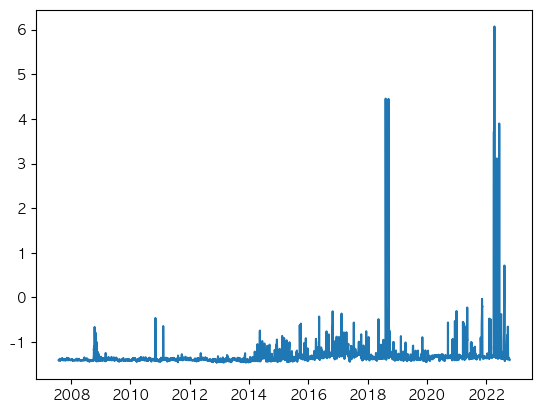

In [1210]:
plt.plot(kurt_skew_df['kurt'])

------------------------------------------

kurt   -1.321748
skew    0.175418
dtype: float64

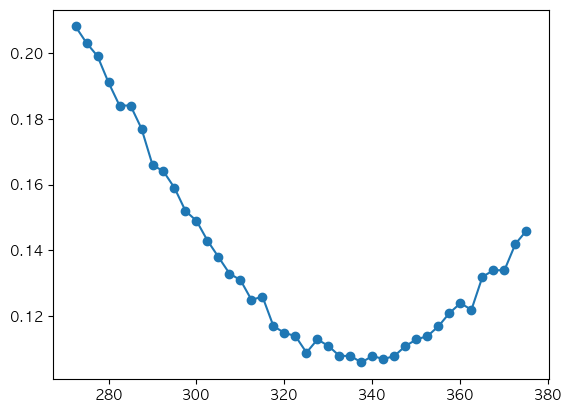

In [537]:
plt.plot(pd.concat([c_iv, p_iv]).sort_index().dropna(), '-o')

In [592]:
test = pd.concat([c_iv, p_iv]).sort_index().dropna()


In [601]:
atm = test.index[np.argmin(np.abs(test.index - spot))]
atm

235.0

In [684]:
df.index[2579]

Timestamp('2018-01-03 00:00:00')

In [799]:
df.index[83]

Timestamp('2007-12-03 00:00:00')

16.514861083022197


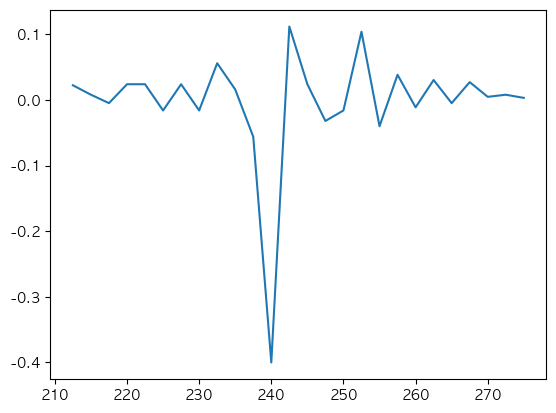

In [803]:
'''date'''
date_idx = df.index[83]
date = dt.datetime.strftime(date_idx, '%Y-%m-%d')
ex_date = new_next_exp(date_idx)
op_ex_date = option_date_creator(1, ex_date[0:4]+'-'+ex_date[5:6])

'''params'''
tau = (dt.datetime.strptime(op_ex_date, '%Y-%m-%d') - date_idx).days / 365
r = rf.loc[date].item()
q = stock_q.loc[date].item()

'''--------------------- close ------------------'''
call_close = df.loc[date, ('C', ex_date, slice(None), '종가')]
put_close  = df.loc[date, ('P', ex_date, slice(None), '종가')]

call_close_df = pd.DataFrame(call_close).reset_index()
put_close_df  = pd.DataFrame(put_close).reset_index()

call_close_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'close')
put_close_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'close')

call_close_df[['strike', 'close']] = call_close_df[['strike', 'close']].astype(float)
put_close_df[['strike', 'close']]  = put_close_df[['strike', 'close']].astype(float)

k_list = np.unique(np.concatenate([call_close_df['strike'].values, put_close_df['strike'].values]))
spot = kospi200.loc[date]

call_list = k_list[np.where(k_list>=spot)]
put_close_list = k_list[np.where(k_list<spot)]

c_close = call_close_df.set_index('strike').loc[call_list]['close'].dropna()
p_close = put_close_df.set_index('strike').loc[put_close_list]['close'].dropna()

'''--------------------- iv ----------------------'''
call_iv = df.loc[date, ('C', ex_date, slice(None), '내재변동성')]
put_iv  = df.loc[date, ('P', ex_date, slice(None), '내재변동성')]

call_iv_df = pd.DataFrame(call_iv).reset_index()
put_iv_df  = pd.DataFrame(put_iv).reset_index()

call_iv_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'iv')
put_iv_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'iv')

call_iv_df[['strike', 'iv']] = call_iv_df[['strike', 'iv']].astype(float)
put_iv_df[['strike', 'iv']]  = put_iv_df[['strike', 'iv']].astype(float)

k_list = np.unique(np.concatenate([call_iv_df['strike'].values, put_iv_df['strike'].values]))
spot = kospi200.loc[date]

call_list = k_list[np.where(k_list>=spot)]
put_list = k_list[np.where(k_list<spot)]

c_iv = call_iv_df.set_index('strike').loc[call_list]['iv'].dropna()
p_iv = put_iv_df.set_index('strike').loc[put_list]['iv'].dropna()

cp_df = pd.concat([p_close, c_close]).sort_index()
interval = (cp_df.index[-1] - cp_df.index[0])/(len(cp_df)-1)
cp_close = cp_df.to_numpy()

g = (cp_close[:-2] + cp_close[2:] - cp_close[1:-1] * 2) / interval**2
plt.plot(cp_df.index[1:-1], g)

print(kurtosis(g, fisher=False))

In [802]:
interval

2.5

In [725]:
p_close.index[1] - p_close.index[0]

2.5

In [778]:
cp_close[2:].shape

(40,)

5.5156112201000305


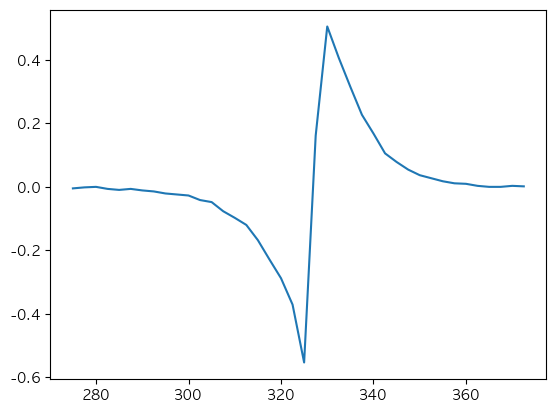

In [787]:
cp_df = pd.concat([p_close, c_close]).sort_index()
interval = (cp_df.index[-1] - cp_df.index[0])/(len(cp_df)-1)
cp_close = cp_df.to_numpy()
atm_close = c_close.to_numpy()[0]
atm_idx = cp_close[np.where(cp_close==atm_close)]
g = (cp_close[:-2] + cp_close[1:-1] - cp_close[2:] * 2) / interval**2
plt.plot(cp_df.index[1:-1], g)

print(kurtosis(g, fisher=False))

In [667]:
bsm_cal_call(spot, c_iv.index, r, q, c_iv, tau)
bsm_cal_put(spot, p_iv.index, r, q, p_iv, tau)

Float64Index([ 31.404822027450123,   31.18430655454106,  28.004105785943715,
               22.778625884090104,  17.404139244351803,  13.754748390529613,
                8.826128315808987,   5.118178037281808,  0.5207729937309651,
              -3.7095777808770976,   -8.24977021321228, -11.926669305911773,
              -15.080465984124942,  -17.67542777776331, -19.448480264524413,
              -20.622237987103055, -21.158866983097568, -20.896314652021296,
              -20.267088912259872,  -19.43591416547941, -17.711523094932005,
              -14.872023462913894, -12.176758178301071, -10.133225935090671,
               -4.668459905060416, -3.8250447055966035, -1.7786170907451435,
               1.4927446384462968],
             dtype='float64', name='strike')

In [609]:
def imp_dist (test, tau, r):
    atm = test.index[np.argmin(np.abs(test.index - spot))]
    g=(np.exp(r*tau)*(test[test.index>atm].values + test[test.index<atm].values - 2 * test[test.index==atm].values)/(test.index[1] - test.index[0])**2)
    return(g)

In [610]:
'''date'''
date_idx = df.index[0]
date = dt.datetime.strftime(date_idx, '%Y-%m-%d')
ex_date = new_next_exp(date_idx)
op_ex_date = option_date_creator(1, ex_date[0:4]+'-'+ex_date[5:6])

'''params'''
tau = (dt.datetime.strptime(op_ex_date, '%Y-%m-%d') - date_idx).days / 365
r = rf.loc[date]

test = pd.concat([c_iv, p_iv]).sort_index().dropna()

imp_dist(test, tau, r)

ValueError: operands could not be broadcast together with shapes (14,) (28,) 

In [539]:
from scipy.stats import kurtosis

iv_list = pd.concat([c_iv, p_iv]).sort_index().dropna()
kurtosis(iv_list, fisher=False)

2.7707561442990554

In [551]:
dt.datetime.strftime(df.index[0], '%Y-%m-%d')

'2007-08-01'

In [560]:
def new_next_exp(today):

    next_mon = today + relativedelta.relativedelta(months=1)
    nnext_mon = next_mon + relativedelta.relativedelta(months=1)

    if today.day < 15:
        result = next_mon
    else:
        result = nnext_mon
        
    return result.strftime("%Y%m")

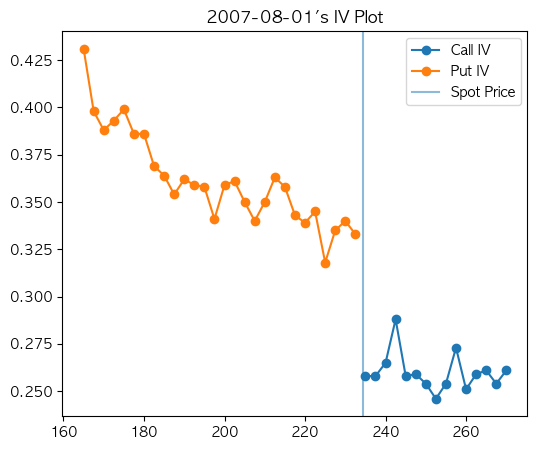

In [636]:
df.index

for date_idx in [df.index[0]]:
    '''특정 일자의 IV Columns'''

    date = dt.datetime.strftime(date_idx, '%Y-%m-%d')
    ex_date = new_next_exp(date_idx)

    call_iv = df.loc[date, ('C', ex_date, slice(None), '내재변동성')]
    put_iv  = df.loc[date, ('P', ex_date, slice(None), '내재변동성')]

    call_iv_df = pd.DataFrame(call_iv).reset_index()
    put_iv_df  = pd.DataFrame(put_iv).reset_index()

    call_iv_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'iv')
    put_iv_df.columns = ('cpflag', 'tick', 'strike', 'feature', 'iv')

    call_iv_df[['strike', 'iv']] = call_iv_df[['strike', 'iv']].astype(float)
    put_iv_df[['strike', 'iv']]  = put_iv_df[['strike', 'iv']].astype(float)

    k_list = np.unique(np.concatenate([call_iv_df['strike'].values, put_iv_df['strike'].values]))
    spot = kospi200.loc[date]

    call_list = k_list[np.where(k_list>=spot)]
    put_list = k_list[np.where(k_list<spot)]

    c_iv = call_iv_df.set_index('strike').loc[call_list]['iv']
    p_iv = put_iv_df.set_index('strike').loc[put_list]['iv']

    plt.figure(figsize=(6, 5))
    plt.title(f"{date}'s IV Plot")
    plt.plot(c_iv, '-o', label='Call IV')
    plt.plot(p_iv, '-o', label='Put IV')
    plt.axvline(spot, label='Spot Price', alpha=0.5)
    plt.legend()
    plt.show()

    iv_list = pd.concat([c_iv, p_iv]).sort_index().dropna()
    kurtosis(iv_list, fisher=False)

### 내재변동성 추정 곡선식

만기를 맞춰야 할 것 같긴 한데...

In [359]:
import numpy as np
import scipy as sp
import scipy.optimize as opt
from scipy.optimize import minimize
import time
import pandas as pd
import matplotlib.pyplot as plt

def svi_2steps(iv,x,init_msigma,maxiter=10,exit=1e-12,verbose=True):
    opt_rmse=1

    def svi_quasi(y,a,d,c):
        return a+d*y+c*np.sqrt(np.square(y)+1)

    def svi_quasi_rmse(iv,y,a,d,c):
        return np.sqrt(np.mean(np.square(svi_quasi(y,a,d,c)-iv)))
    
    # 计算a,d,c
    def calc_adc(iv,x,_m,_sigma):
        y = (x-_m)/_sigma
        s = max(_sigma,1e-6)
        bnd = ((0,0,0),(max(iv.max(),1e-6),2*np.sqrt(2)*s,2*np.sqrt(2)*s))
        z = np.sqrt(np.square(y)+1)
        
        # 此处等价于坐标轴旋转45°，这样写运行更快
        A = np.column_stack([np.ones(len(iv)),np.sqrt(2)/2*(y+z),np.sqrt(2)/2*(-y+z)])
        
        a,d,c = opt.lsq_linear(A,iv,bnd,tol=1e-12,verbose=False).x
        return a,np.sqrt(2)/2*(d-c),np.sqrt(2)/2*(d+c)
    

    def opt_msigma(msigma):
        _m,_sigma = msigma
        _y = (x-_m)/_sigma 
        _a,_d,_c = calc_adc(iv,x,_m,_sigma)
        return np.sum(np.square(_a+_d*_y+_c*np.sqrt(np.square(_y)+1)-iv))

    for i in range(1,maxiter+1):
        #a_star,d_star,c_star = calc_adc(iv,x,init_msigma)       
        m_star,sigma_star = opt.minimize(opt_msigma,
                                         init_msigma,
                                         method='Nelder-Mead',
                                         bounds=((2*min(x.min(),0), 2*max(x.max(),0)),(1e-6,1)),
                                         tol=1e-12).x
        
        a_star,d_star,c_star = calc_adc(iv,x,m_star,sigma_star)
        opt_rmse1 = svi_quasi_rmse(iv,(x-m_star)/sigma_star,a_star,d_star,c_star)
        if verbose:
            print(f"round {i}: RMSE={opt_rmse1} para={[a_star,d_star,c_star,m_star,sigma_star]}     ")
        if i>1 and opt_rmse-opt_rmse1<exit:
            break
        opt_rmse = opt_rmse1
        init_msigma = [m_star,sigma_star]
        
    result = np.array([a_star,d_star,c_star,m_star,sigma_star,opt_rmse1])
    if verbose:
        print(f"\nfinished. params = {result[:5].round(10)}")
    return result

def quasi2raw(a,d,c,m,sigma):
    return a,c/sigma,d/c,m,sigma

def svi_raw(x,a,b,rho,m,sigma):
    centered = x-m
    return a+b*(rho*centered+np.sqrt(np.square(centered)+np.square(sigma)))

def svi_quasi(x,a,d,c,m,sigma):
    y = (x-m)/sigma
    return a+d*y+c*np.sqrt(np.square(y)+1)


In [468]:
stock_q = stock.get_index_fundamental('20070801', '20221130', '1028')[['배당수익률']] / 100
rf = pd.read_csv('./Data/rf.csv', parse_dates=['Date'], index_col=['Date'])
futures = pd.read_csv('./Data/futures.csv',encoding='euckr', parse_dates=['일자'], index_col=['일자']).sort_index()
historical_vol = kospi200.pct_change().dropna().rolling(255).std().loc['20070801':] * np.sqrt(255)

today = '2018-01-03'
mat_date = option_date_creator(1, '2018-02')

tau = dt.datetime.strptime(mat_date, '%Y-%m-%d') - dt.datetime.strptime(today, '%Y-%m-%d')
tau = np.array([tau.days]) / 255

q = np.array([stock_q.loc[today].item()])
r = rf.loc[today].item()
f = futures.loc[today]['종가']
sig = historical_vol.loc[today].item()

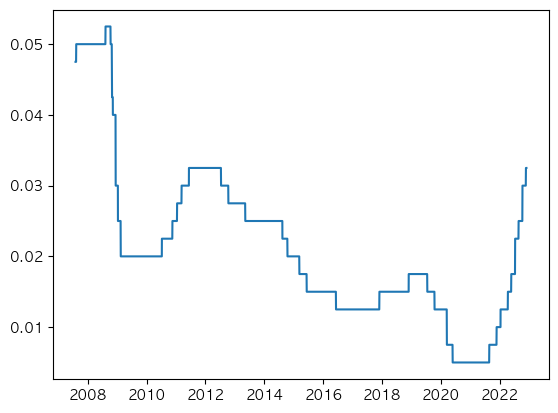

In [570]:
plt.plot(rf)

In [1266]:
data = pd.DataFrame(pd.concat([c_iv, p_iv]).sort_index().dropna())

init = data

y1_l = init.iloc[0].item()
y2_l = init.iloc[1].item()
x1_l = init.index[0].item()
x2_l = init.index[1].item()

y1_r = init.iloc[-2].item()
y2_r = init.iloc[-1].item()
x1_r = init.index[-2].item()
x2_r = init.index[-1].item()

l_a = (- (y2_l - y1_l) / (x2_l - x1_l))
l_b = (x1_l * y2_l - x2_l * y1_l) / (x1_l - x2_l)
r_a = (y2_r - y1_r) / (x2_r - x1_r)
r_b = (x1_r * y2_r - x2_r * y1_r) / (x1_r - x2_r)

a = l_b + l_a * ((r_b - l_b)/(l_a - r_a))
b = (r_a -l_a)/2
rho = (r_a + l_a) / (r_a - l_a)
m = l_a * (r_b-l_b) / (b*(l_a-r_a)*(rho-1))
sig = init.values[np.argmin(init)].item()**2


In [1267]:
# tttt = np.linspace(init.index[0], init.index[-1], 100)
tttt = init.index
ttt = np.log(tttt/f)
a + b * (rho * (ttt - m) + np.sqrt((ttt-m)**2 + sig**2))

Float64Index([-30.438039486466153,  -30.43708543693026, -30.436143093819112,
              -30.435212173330285, -30.434292401857817,  -30.43338351551057,
                -30.4324852596568, -30.431597388496414, -30.430719664657033,
              -30.429851858813606, -30.428993749327674,  -30.42814512190853,
               -30.42730576929165,  -30.42647549093482,  -30.42565409273078,
              -30.424841386734215,   -30.4240371909043, -30.423241328859945,
              -30.422453629647123, -30.421673927518725, -30.420902061725144,
              -30.420137876315664, -30.419381219948775, -30.418631945713003,
              -30.417889910954955,  -30.41715497711698, -30.416427009581184,
              -30.415705877522328,  -30.41499145376588,  -30.41428361465387,
               -30.41358223991614,  -30.41288721254824,  -30.41219841869355,
               -30.41151574753195, -30.410839091172306, -30.410168344550755,
              -30.409503405332032, -30.408844173816533,   -30.4081905528501,

In [1264]:

data = pd.DataFrame(pd.concat([c_close, p_close]).sort_index().dropna())
#data.index = [today]


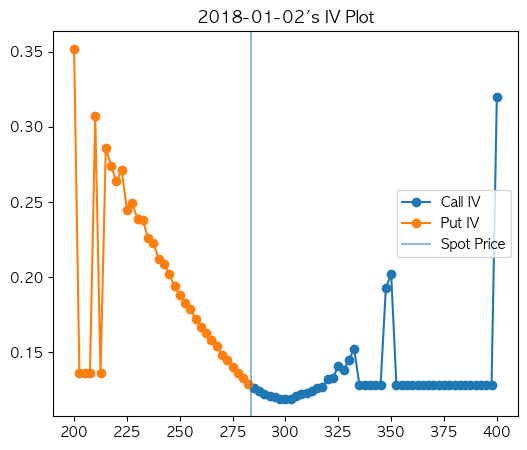

In [1269]:
# c_iv = call_close_df.set_index('strike').loc[call_list]['종가']
# p_iv = put_close_df.set_index('strike').loc[put_list]['종가']

plt.figure(figsize=(6, 5))
plt.title("2018-01-02's IV Plot")
plt.plot(c_iv, '-o', label='Call IV')
plt.plot(p_iv, '-o', label='Put IV')
plt.axvline(spot, label='Spot Price', alpha=0.5)
plt.legend()
plt.show()

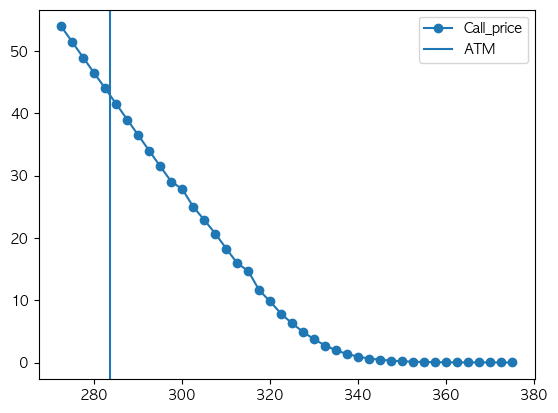

In [1271]:
stock_q = stock.get_index_fundamental('20070801', '20221130', '1028')[['배당수익률']] /100
rf = pd.read_csv('./Data/rf.csv', parse_dates=['Date'], index_col=['Date'])
futures = pd.read_csv('./Data/futures.csv',encoding='euckr', parse_dates=['일자'], index_col=['일자']).sort_index()

today = '2018-01-03'
mat_date = option_date_creator(1, '2018-02')

tau = dt.datetime.strptime(mat_date, '%Y-%m-%d') - dt.datetime.strptime(today, '%Y-%m-%d')
tau = np.array([tau.days]) / 365

q = np.array([stock_q.loc[today].item()])
r = rf.loc[today].item()
f = futures.loc[today]['종가']

plt.plot(call_df.set_index('strike')['close'], '-o', label='Call_price')
plt.axvline(spot, label='ATM')
plt.legend()
plt.show()

In [1272]:
import scipy.stats as stats

def d1_cal (s, k ,r, q, iv, t) :
    return (np.log(s/k) + (r-q+iv**2/2)*t)/(iv*np.sqrt(t))

def d2_cal (s, k ,r, q, iv, t) :
    return d1_cal(s,k,r,q,iv,t) - iv * np.sqrt(t)

def N_cal (d1):
    return stats.norm.pdf(d1)

def Nprime_cal (d1):
    return np.exp(-d1**2/2) / np.sqrt(2*np.pi)

def bsm_cal_call (s, k ,r, q, iv, t):
    d1 = d1_cal(s, k ,r, q, iv, t)
    d2 = d2_cal(s, k ,r, q, iv, t)
    return s*np.exp(-q*t)*N_cal(d1)-k*np.exp(-r*t)*N_cal(d2)

def bsm_cal_put (s, k ,r, q, iv, t):
    d1 = d1_cal(s, k ,r, q, iv, t)
    d2 = d2_cal(s, k ,r, q, iv, t)
    return k*np.exp(-r*t)*N_cal(-d2)-k*np.exp(-q*t)*N_cal(-d1)

def sensitivity_cal (s, k ,r ,q, iv, t):
    d2 = d2_cal(s, k,r,q,iv,t)

    return -np.exp(-r*t) * N_cal(d2)

def spd_cal (s, k ,r ,q, iv, t):
    d2 = d2_cal(s,k,r,q,iv,t)
    return Nprime_cal(d2) / ((iv) * k * np.sqrt(tau*2*np.pi))

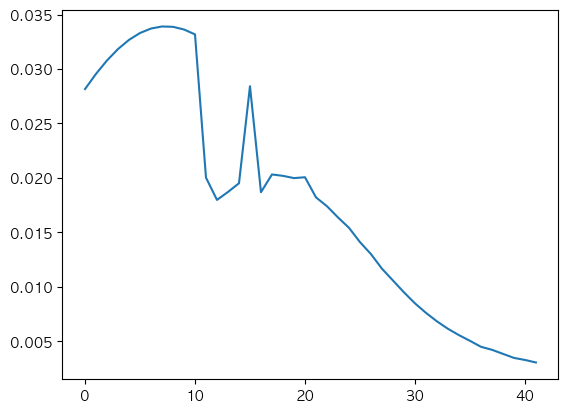

In [1273]:
sig = historical_vol.loc[today]
sig

0.10240954632817309

In [1274]:
test_close = call_close_df.set_index('strike')[['close']].dropna()
test_iv = call_iv_df.set_index('strike')[['iv']].dropna()

k = test_close.index.to_numpy().reshape(-1)
close = test_close.to_numpy().reshape(-1)
iv = test_iv.to_numpy().reshape(-1)

call_bsm = bsm_cal_call(spot, k, r, q, sig, tau)
sensitivity = sensitivity_cal(spot, k, r, q, sig, tau)
spd = spd_cal(spot, k, r, q, sig, tau)

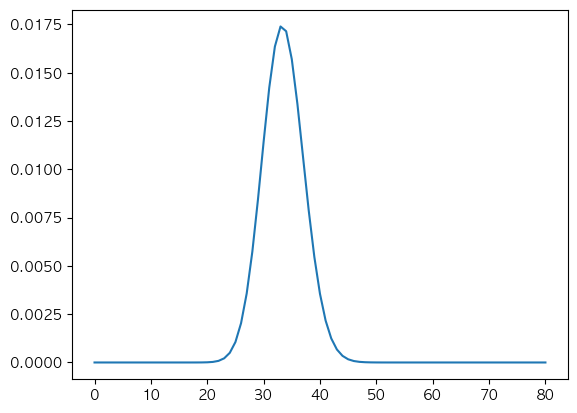

In [1275]:
plt.plot(spd)

In [1260]:
len(k[np.where(k < spot)])

34

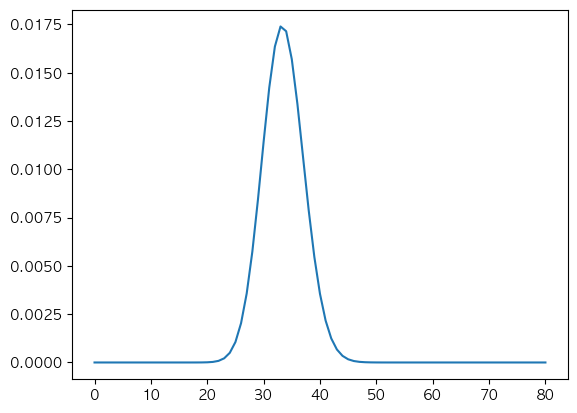

In [1281]:
plt.plot(spd)

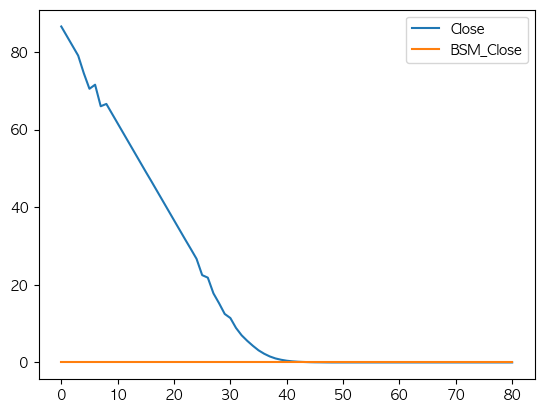

In [1282]:
plt.plot(close, label='Close')
plt.plot(call_bsm, label='BSM_Close')
plt.legend()
plt.show()

In [1335]:
import yfinance as yf
test = yf.download('005930.KS')

[*********************100%***********************]  1 of 1 completed


In [1305]:
test['Adj Close']

Date
2000-01-04     4591.915527
2000-01-05     4193.598633
2000-01-06     4223.661133
2000-01-07     4163.537598
2000-01-10     4336.392578
                  ...     
2022-11-28    60100.000000
2022-11-29    60600.000000
2022-11-30    62200.000000
2022-12-01    62600.000000
2022-12-02    60400.000000
Name: Adj Close, Length: 5753, dtype: float64

In [1350]:
test = test.loc['2019':]
test = test.iloc[-131:]
stock_path = test['Adj Close'].to_numpy().reshape(-1,1)

In [1285]:
from delta_hedging import *


In [1351]:

inputs = {
    's0' :39400,
    'k' : 42000,
    'rf' : 0.04,
    'sigma' : 0.46,
    'imvol' : 0.46,
    'T' : 1,
    'mu' : 0.04,
    'q' : 0,
    'interval' : 1/260,
    'time_step' : 130,
    'simul_num' : 1000,
    'num_shares' : 100000
}
dh = delta_hedging(inputs)

In [1352]:
a = pd.DataFrame(data=np.round(stock_path, 1)).T.iloc[[0]].T
a = a.rename(columns={0:0})

delta_path = np.round(dh.path_delta(stock_path),3)
b = pd.DataFrame(data=delta_path).T.iloc[[0]].T
b = b.rename(columns={0:1})

path_delta_shares_ch = np.round(dh.path_changes(dh.path_delta_shares(stock_path)),0)
c = pd.DataFrame(data=path_delta_shares_ch).T.iloc[[0]].T
c = c.rename(columns={0:2})

'''divided by 1000'''
path_delta_shares_cost_ch = np.round(dh.path_changes(dh.path_delta_shares_cost(stock_path)) / 1000,1)
d = pd.DataFrame(data=path_delta_shares_cost_ch).T.iloc[[0]].T
d = d.rename(columns={0:3})

path_delta_hedged_cum = np.round(dh.path_delta_hedged_cum(stock_path) / 1000,1)
e = pd.DataFrame(data=path_delta_hedged_cum).T.iloc[[0]].T
e = e.rename(columns={0:4})

delta_hedge_int_cost = np.round(dh.delta_hedging_int_cost(stock_path) / 1000, 1)
f = pd.DataFrame(data=delta_hedge_int_cost).T.iloc[[0]].T
f = f.rename(columns={0:5})

tmp = pd.concat([a, b, c, d, e, f], axis=1).\
      rename(columns={0:'Stock Price', 1:'Delta', 2:'#Purchased_ch', 3:'$Purchased_ch/1000', 4:'Cum $ Cost/1000', 5:'int $ Cost/1000'})
tmp

,Stock Price,Delta,#Purchased_ch,$Purchased_ch/1000,Cum $ Cost/1000,int $ Cost/1000
0,39309.4,0.508,50821.0,1997735.4,1997735.4,307.3
1,39443.7,0.512,354.0,20791.4,2020063.5,310.8
2,41055.5,0.560,4863.0,282114.8,2303732.3,354.4
3,41682.3,0.578,1806.0,110419.8,2415924.1,371.7
4,40742.1,0.550,-2843.0,-170206.1,2247576.5,345.8
...,...,...,...,...,...,...
126,44702.9,0.871,16167.0,816277.5,4104451.4,631.5
127,44748.4,0.906,3478.0,159610.6,4267219.3,656.5
128,44839.3,0.950,4439.0,207301.7,4477803.5,688.9
129,45021.2,0.993,4250.0,208625.2,4689873.1,721.5
